- [ ] You should present a Jupyter notebook portfolio, with Markdown cells inserted at appropriate places to explain your code and describe your analysis.
- [ ] This portfolio should include the **aims, methodology, results and discussion** of your data analysis in a concise and readable fashion.

- Exposition: Your portfolio should b e well organised, and you should aim to write concisely. For each question, you should explain the problem, the data and the aims of the analysis. You should also describe and discuss the machine learning techniques that you have used and the data preparation steps you did (when necessary).
- Data visualisations: Your portfolio should include appropriate and well-presented visualisations that are meaningful to the analysis. For instance, when presenting a plot, you should provide readable labels, axis values, etc.
- Application of techniques: Your portfolio should include the correct use of the machine learning techniques and the interpretation of the results obtained from these techniques.
- Presentation of results: Describe the results of your analysis and their interpretations. Software output is not a valid answer. You must format and present your answer appropriately (tables, graphs, important measures, etc.). You should not add irrelevant information when presenting the results. 
- Discussion: Based on your results, describe the conclusions of your analysis.

In [1]:
# !pip install -q ipympl
!pip install -q tabulate

# A model for diagnosing cancer

## Exploring Dataset

Determining whether a tumour is malignant or benign is one of the challenging aspects when treating cancer. The growth rate of benign tumors is typically slow, and they don't have the ability to spread. On the other hand, malignant tumors tend to grow quickly, invade and damage surrounding healthy tissues, and can spread to other parts of the body. Therefore, developing an accurate classification model that can differentiate between benign and malignant tumors is crucial in ensuring that patients receive the appropriate treatment and care. Machine learning techniques can help identify cancer types by extracting the differences in cell nucleus features.

In this part of the assignment, we will extend the analysis on the Breast Cancer Wisconsin (diagnostic) dataset and try to build a model that can be used on clinical setting. 

The breast-cancer.csv data set provided contains:

1. Patient ID number
2. Diagnosis (M = malignant, B = benign)
3. Ten cell nucleus features, namely:
   * radius (mean of distances from centre to points on the perimeter)
   * texture (standard deviation of grayscale values)
   * perimeter
   * area
   * smoothness (local variation in radius lengths)
   * compactness (perimeter2 / area - 1.0)
   * concavity (severity of concave portions of the contour)
   * concave points (number of concave portions of the contour)
   * symmetry
   * fractal dimension (‘coastline approximation’ - 1)

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

data = pd.read_csv('breast-cancer.csv')
data.head()

,id,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,fractal_dimension_mean
0,842302,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871
1,842517,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667
2,84300903,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999
3,84348301,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744
4,84358402,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883


To facilitate the construction of a machine learning model, the diagnostic labels in the dataset will be encoded appropriately. In the given dataset, the label "malignant" is represented by the letter "M," while the label "benign" is represented by the letter "B." By encoding the labels in this manner, we can prepare the data for training and utilize machine learning algorithms effectively.

> M = malignant

> B = benign




In [3]:
data.isnull().sum()

id                        0
diagnosis                 0
radius_mean               0
texture_mean              0
perimeter_mean            0
area_mean                 0
smoothness_mean           0
compactness_mean          0
concavity_mean            0
concave points_mean       0
symmetry_mean             0
fractal_dimension_mean    0
dtype: int64

The output of the command `data.isnull().sum()` reveals that there are no missing values present in any of the columns within the Breast Cancer Wisconsin dataset. This suggests that the dataset is complete, with no null or missing data points, enabling us to proceed with the analysis without the need for imputation or handling missing values.

In binary classification problems, it is common to designate one class as the positive class and the other as the negative class, based on the specific problem and analysis objectives. Considering the significance of correctly identifying malignant tumors, I will redefine the labels by assigning the value 1 to represent malignant cases and 0 to represent benign cases. This relabeling will help prioritize the accurate identification of malignant tumors within the dataset.

> M = 1

> B = 0


In [4]:
# Encode diagnosis labels into numerical values
data['diagnosis'] = data['diagnosis'].map({'M': 1, 'B': 0})

# Verify the encoding
print(data['diagnosis'].value_counts())

0    357
1    212
Name: diagnosis, dtype: int64


Based on the provided data, there are 357 cases of benign tumors and 212 cases of malignant tumors. 

Considering that the patient ID does not hold any significance in the diagnosis, we will exclude it from the list of features. Consequently, we will separate the features from the target variable, enabling us to train our model effectively.

In [5]:
# Separate features (X) and target variable (y)
X = data.drop(['id', 'diagnosis'], axis=1)  # Drop the 'id' and 'diagnosis' columns to get the features
y = data['diagnosis']  # Select the 'diagnosis' column as the target variable

## Visualization of dataset

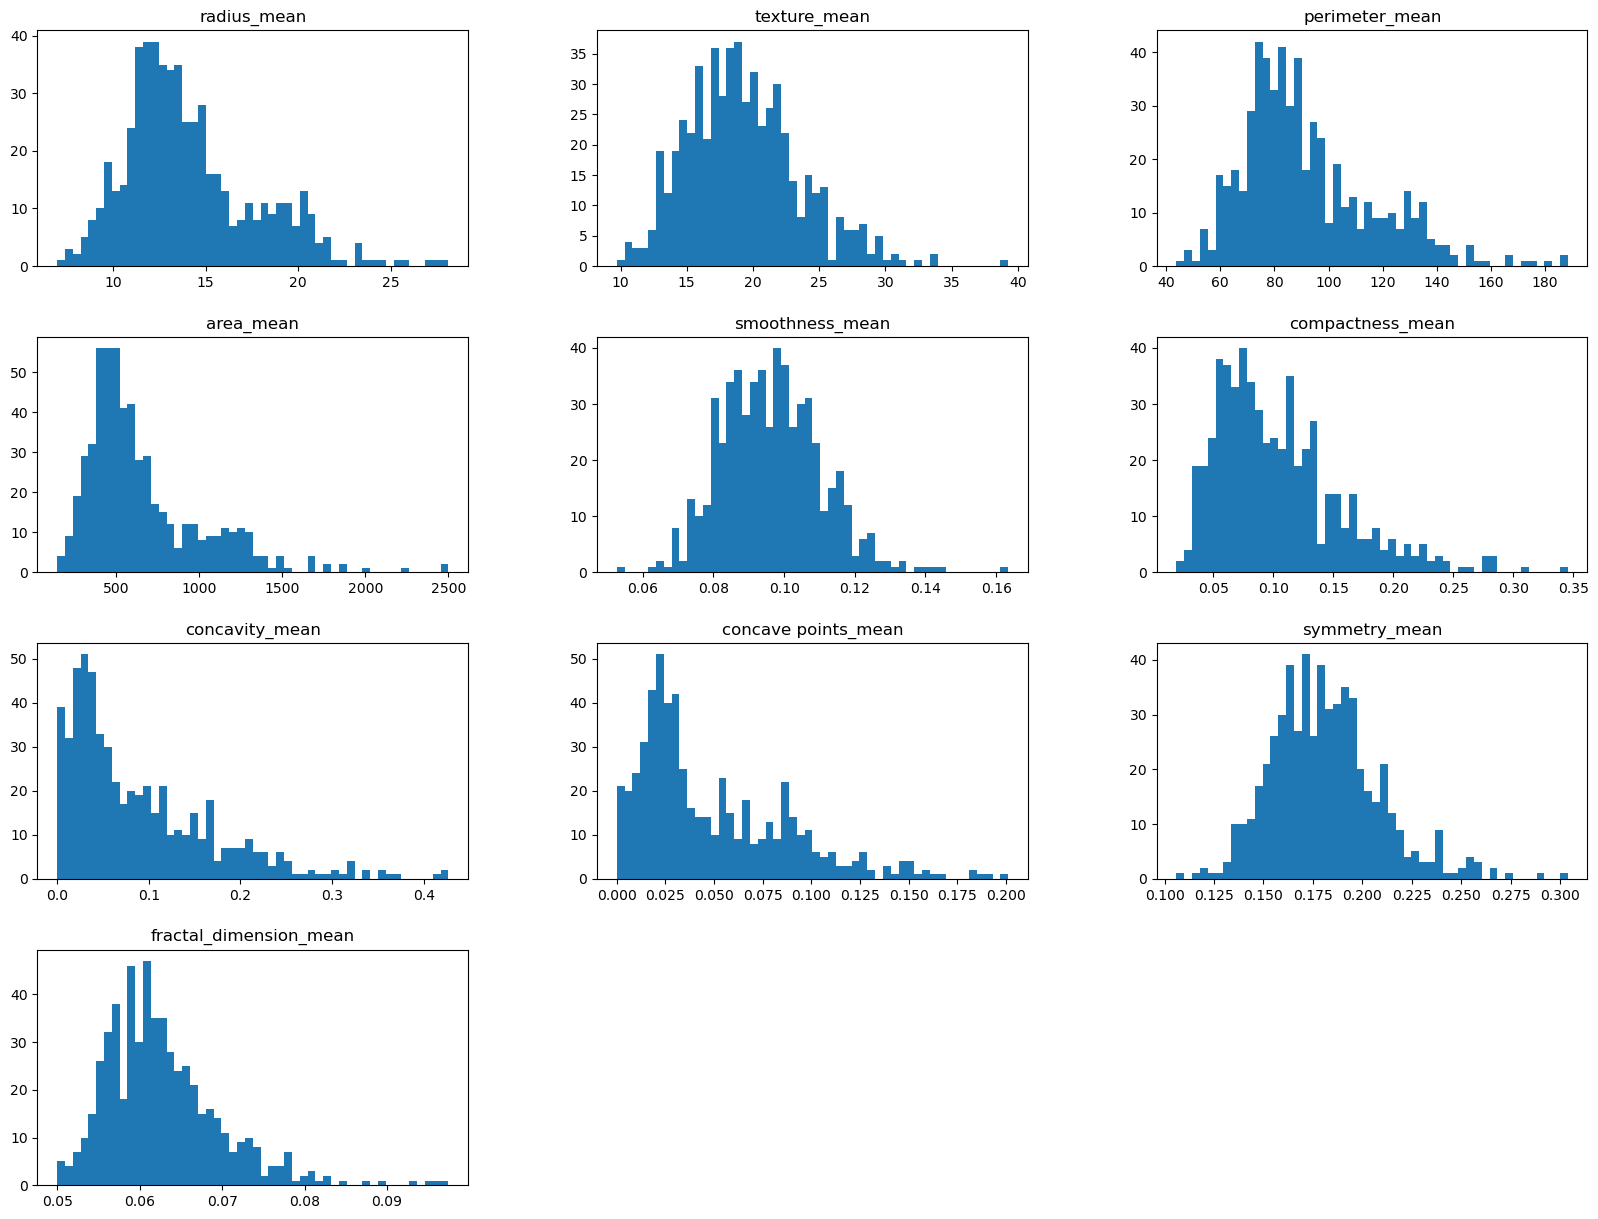

In [6]:
X.hist(bins=50, figsize=(20, 15), grid=False)
plt.show()

The observation that most of the features are right-skewed indicates that they might require certain transformations to achieve a more normal distribution. 

Skewed data can have different impacts on logistic regression and decision tree models:

**1. Logistic Regression:**
   - Skewed data: Logistic regression assumes a linear relationship between predictors and the log-odds of the target variable. If predictors are heavily skewed, this assumption may be violated, potentially leading to biased model estimates.
   - Transformation: Transforming skewed predictors in logistic regression can help achieve a more linear relationship and improve model performance. Common transformations include logarithmic, power, or Box-Cox transformations.

**2. Decision Tree:**
   - Skewed data: Decision trees can handle skewed data without requiring transformation. Skewness does not affect the ability of decision trees to identify informative splits based on the ordering of predictors.
   - Impurity measures: Decision tree algorithms use impurity measures like Gini index or entropy, which are not influenced by data skewness.

In our case, since the predictors are not heavily skewed, we won't perform any data transformation. However, since the predictors have different units of measurement, we might consider scaling the data to ensure all features are on a similar scale for modeling purposes.

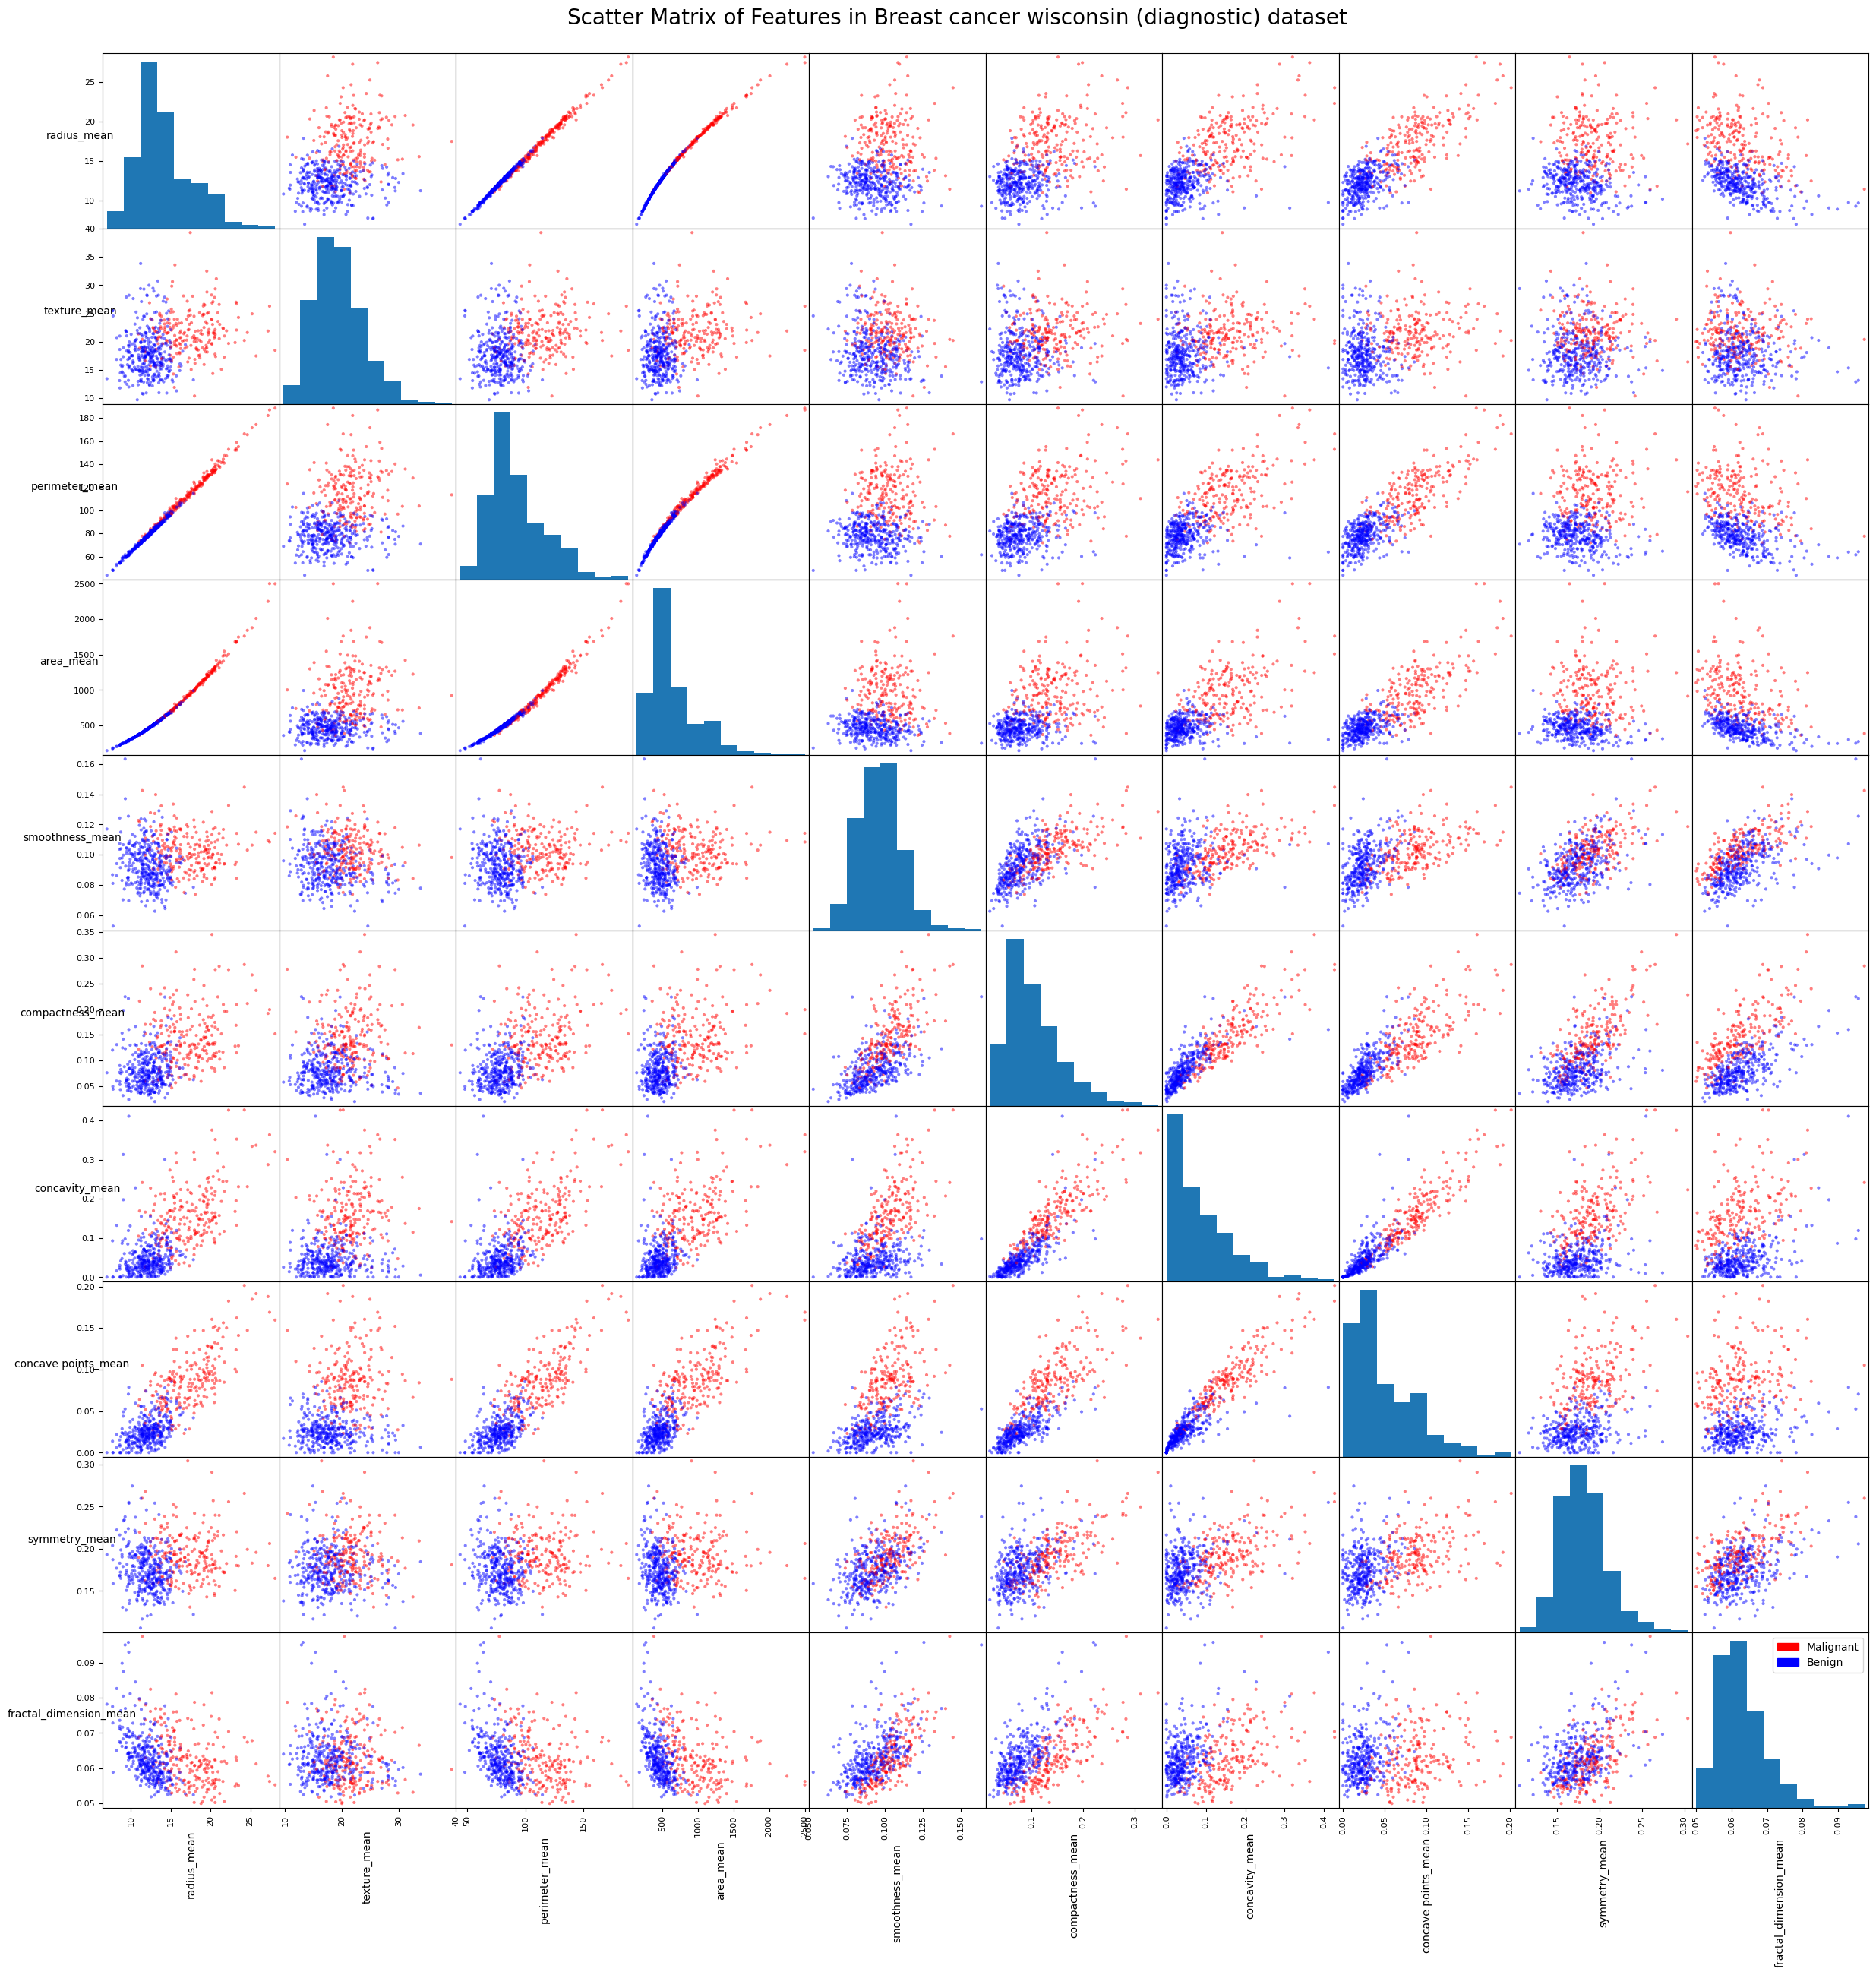

In [7]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

# Define colors for malignant and benign data points
# Red - Malignant
# Blue - Benign
colors = ['red' if label == 1 else 'blue' for label in y]

scatter_matrix_plot = scatter_matrix(X, figsize=(30, 30), diagonal='hist', color=colors)

# Create empty scatter plots with the same colors as our actual data points
red_patch = mpatches.Patch(color='red', label='Malignant')
blue_patch = mpatches.Patch(color='blue', label='Benign')

for i, axs in enumerate(scatter_matrix_plot):
    for j, ax in enumerate(axs):
        if i == len(scatter_matrix_plot) - 1:
            ax.set_xlabel(X.columns[j], rotation=90)
        if j == 0:
            ax.set_ylabel(X.columns[i], rotation=0)          

for ax in scatter_matrix_plot.ravel():
    ax.tick_params(axis='x', labelrotation = 90)
    ax.tick_params(axis='y', labelrotation = 0)
    
# Add legend
plt.legend(handles=[red_patch, blue_patch], loc='best')

plt.suptitle('Scatter Matrix of Features in Breast cancer wisconsin (diagnostic) dataset', fontsize=20, y=0.9)      
plt.show()

The scatterplot above visualizes the relationship between each feature in the dataset. The data instances are color-coded, with `red` representing `malignant` instances and `blue` representing `benign` instances. From the scatterplot, it is apparent that certain features exhibit correlation with one another, either in a linear or non-linear fashion. Some of these correlations can be inferred directly from the feature definitions. For example, the perimeter is linearly correlated with the radius, and the area is polynomially related to the radius.

Formulas for perimeter and area:

- Perimeter: The perimeter is the total length of the boundary of a shape. In the case of a circle, the perimeter is directly related to the radius `r` and can be calculated using the formula:
 
 <center>Perimeter = $2\pi r$</center>

- Area: The area is the measure of the surface enclosed by a shape. For a circle, the area is polynomially related to the radius `r` and can be calculated using the formula:

<center>Area = $\pi r^2$</center>
 
In these formulas, `r` represents the radius of the circle. </center>

## Finding Correlation among features

To investigate collinearity further and identify features that are strongly correlated, we can plot a correlation matrix heatmap. This heatmap provides a visual representation of the pairwise correlations between features. By analyzing the heatmap and scatterplot, we can determine which features exhibit high correlation coefficients and consider removing one of the features from pairs with strong correlation.

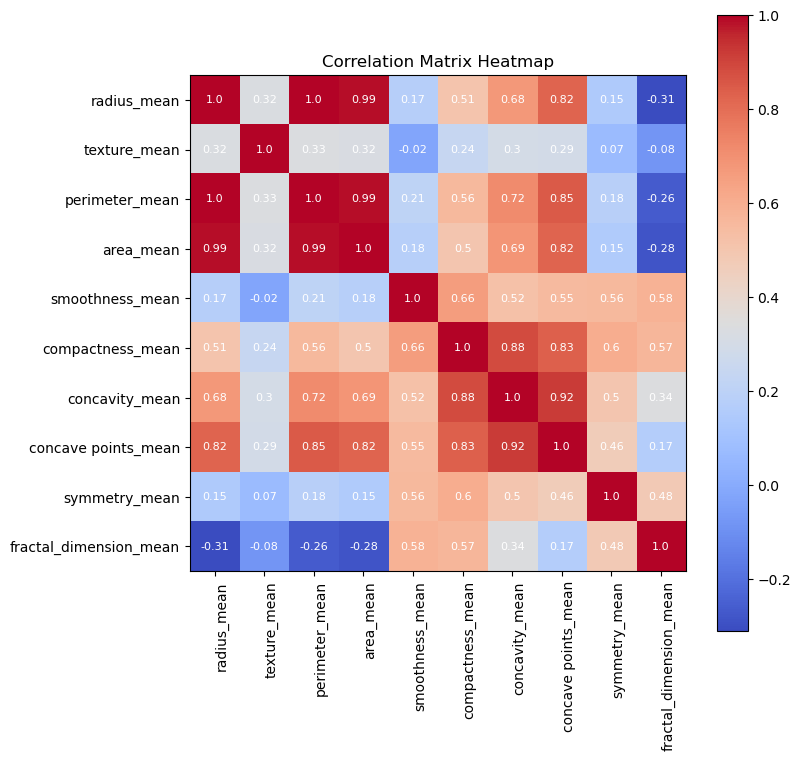

In [8]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# calculate the correlation matrix
corr_matrix = X.corr()

# create the heatmap plot
fig, ax = plt.subplots(figsize=(8,8))
im = ax.imshow(corr_matrix, cmap='coolwarm')

# add a colorbar
cbar = ax.figure.colorbar(im, ax=ax)

# set the axis labels
ax.set_xticks(np.arange(len(corr_matrix.columns)))
ax.set_yticks(np.arange(len(corr_matrix.columns)))
ax.set_xticklabels(corr_matrix.columns, fontsize=10)
ax.set_yticklabels(corr_matrix.columns, fontsize=10)

# rotate the tick labels and set their alignment
plt.setp(ax.get_xticklabels(), rotation=90, ha="right", rotation_mode="anchor")

# add the correlation coefficients in each cell of the heatmap
for i in range(len(corr_matrix.columns)):
    for j in range(len(corr_matrix.columns)):
        text = ax.text(j, i, round(corr_matrix.iloc[i, j], 2), ha="center", va="center", color="w", fontsize=8)

# set the title
ax.set_title("Correlation Matrix Heatmap")

# show the plot
plt.show()

Based on the provided heatmap, it is evident that certain features exhibit strong correlations. For instance, the feature "perimeter mean" and "area mean" are directly correlated with the "radius mean," as observed in the scatter plot. Additionally, the features "compactness mean," "concave points mean," and "concavity mean" show high correlation among themselves. 

Considering these correlations, we can drop the features that are highly correlated and retain only one representative feature from each group for our model. The correlated features and their corresponding groups are as follows:

1. Correlated features with "radius mean":
   - "perimeter mean"
   - "area mean"

2. Correlated features with "compactness mean":
   - "concave points mean"
   - "concavity mean"

3. Other features:
   - "texture mean"
   - "smoothness mean"
   - "symmetry mean"
   - "fractal dimension mean"

Therefore, to avoid multicollinearity and maintain independence among the features, we will remove the correlated columns and retain only the independent features for our model.

In [9]:
X = X[['radius_mean', 'texture_mean', 'smoothness_mean', 'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean']]

Nex, we will perform stratified sampling to split the data into training and test sets in 85/25 ration, to ensure that the proportion of target labels is maintained in both sets. This will ensure that our training and test sets are representative of the entire dataset.

In [10]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=123, stratify=y)

Scaling data is a separate consideration from handling data skewness. Scaling refers to the process of transforming the values of the predictors to a consistent scale, typically between a specific range or with a mean of 0 and a standard deviation of 1. The purpose of scaling is to ensure that all predictors contribute equally to the model and to prevent variables with larger scales from dominating the modeling process.

Here's how scaling relates to logistic regression and decision trees:

**1. Logistic Regression:**
   - Scaling: Logistic regression models can benefit from scaling the predictors, especially when the predictors have different scales. Scaling the predictors helps in cases where the optimization algorithm used to fit the logistic regression model (e.g., gradient descent) converges faster or performs better with scaled data.
   - Standardization: Common scaling techniques in logistic regression include standardization (subtracting the mean and dividing by the standard deviation) or normalization (scaling values between a specified range, e.g., 0-1).

**2. Decision Tree:**
   - Scaling: Decision trees, in general, are not affected by scaling since the algorithm makes decisions based on relative ordering rather than absolute values. Therefore, scaling is not necessary for decision trees.
   - Interpretability: Scaling does not impact the interpretability of decision trees since the splits are determined by the relative ordering of predictors.

In summary, while scaling can be beneficial for logistic regression models to ensure fair contribution of predictors, it is generally not necessary for decision trees. However, scaling can still be applied to decision tree models if desired, without affecting their interpretability.

For our dataset, we will scale the data when training our logistic regression model, while leaving the data unscaled for decision trees.

In [11]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()

# Fit the scaler on the training data and transform it
X_train_scaled = std_scaler.fit_transform(X_train)

# Use the fitted scaler to transform the test data
X_test_scaled = std_scaler.transform(X_test)

To facilitate further analysis and visualization, we can associate the feature names with the scaled data obtained from the scaling process. By attaching the feature names, we can plot and examine the scaled features, allowing for better insights and interpretation.

In [12]:
# Create new DataFrames with the scaled data and feature names
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X_train.columns)
X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X_train.columns)

## Logistic Regression

### Tuning hyperparameter for Logistic Regression

To optimize the hyperparameters for logistic regression, we can employ techniques such as grid search or random search in conjunction with cross-validation.

1. Define the search space for hyperparameters: Specify the range or a list of values for each hyperparameter that you wish to explore. Let's review the explanation of the hyperparameters and their corresponding values:

   - 'C': The 'C' parameter regulates the inverse of the regularization strength. Smaller 'C' values lead to stronger regularization, which can prevent overfitting by penalizing large coefficient values. The provided values in the search space, such as [0.01, 0.1, 1, 10, 100], represent different levels of regularization strength to be tested.

   - 'penalty': The 'penalty' parameter determines the type of regularization to be applied. In this case, 'l2' is employed, representing L2 regularization (Ridge regression). L2 regularization adds the squared magnitudes of the coefficients to the loss function, encouraging smaller coefficient values. Only 'l2' is included in the search space in this example.

   - 'class_weight': The 'class_weight' parameter addresses class imbalance by assigning different weights to various classes. The value 'None' represents the default setting, where all classes are treated equally. Conversely, 'balanced' automatically adjusts the weights based on the class frequencies in the input data.

   - 'fit_intercept': The 'fit_intercept' parameter determines whether an intercept term should be included in the logistic regression model. When set to 'True', an intercept is included, while 'False' excludes it.

2. Select a scoring metric: Choose an appropriate metric for evaluating the performance of different hyperparameter combinations. Options include accuracy, precision, recall, F1-score, or any other metric that suits your specific problem. **In our case, since we require both high precision and high recall, we will use the F1-score as the scoring metric.**

3. Set up the cross-validation strategy: Decide on the number of folds or the cross-validation strategy to use. Common choices include k-fold cross-validation or stratified k-fold cross-validation.

4. Conduct the hyperparameter search:
   - Grid Search: Conduct an exhaustive search over all possible combinations of hyperparameters using GridSearchCV from scikit-learn. It evaluates the model performance for each combination through cross-validation and selects the best combination.




In [13]:
from sklearn.model_selection import GridSearchCV
from sklearn.linear_model import LogisticRegression

param_grid = {
    'C': [0.01, 0.1, 1, 10, 100],
    'penalty': ['l2'],
    'class_weight': [None, 'balanced'],
    'fit_intercept': [True, False],
   }

grid_search = GridSearchCV(LogisticRegression(), param_grid, scoring='f1', cv=5)
grid_search.fit(X_train_scaled, y_train)

grid_search.best_params_

{'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2'}

The `param_grid` dictionary in the code snippet defines the grid of hyperparameters to be explored during the grid search process for the logistic regression model. It specifies different values to be tested for each hyperparameter.

The grid search algorithm will systematically evaluate multiple combinations of these hyperparameters and select the best combination based on the specified scoring metric.

In the given example, the combination `'{'C': 10, 'class_weight': 'balanced', 'fit_intercept': True, 'penalty': 'l2'}` represents a specific set of hyperparameters that have been identified as the best choice according to the results of the grid search. It suggests using a regularization strength (`C`) of 10, employing balanced class weights, including an intercept term (`fit_intercept` set to True), and applying L2 regularization (`penalty` set to 'l2').

### Training Logistic Regression Model with optimal hyperparameters

In [14]:
log_reg = LogisticRegression(C=10, class_weight='balanced', fit_intercept=True, penalty='l2')
log_reg.fit(X_train_scaled, y_train)

LogisticRegression(C=10, class_weight='balanced')

(303, 6)
(180, 6)


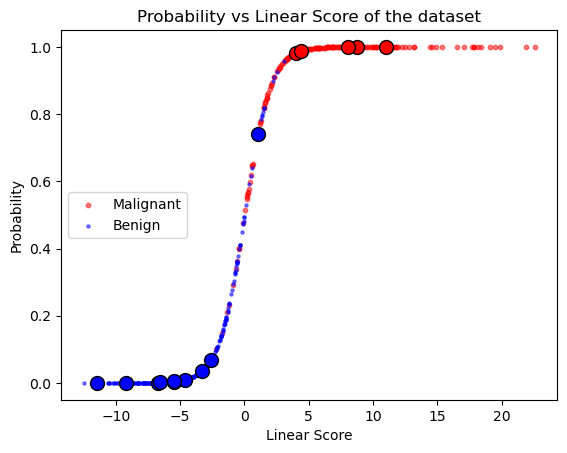

In [15]:
import math
import numpy as np
import matplotlib.pyplot as plt

# Filter X_train_scaled based on Y_train_s values equal to 1
X_subset_malignant = X_train_scaled[y_train == 1]
X_subset_benign = X_train_scaled[y_train == 0]

# Calculate the scores for the subset using the logistic regression coefficients and intercept
X_scores_malignant = np.dot(X_subset_malignant, log_reg.coef_.reshape(-1, 1)) + log_reg.intercept_
X_scores_benign = np.dot(X_subset_benign, log_reg.coef_.reshape(-1, 1)) + log_reg.intercept_

# Print the scores for the subset
print(X_subset_benign.shape)
print(X_subset_malignant.shape)

sigmoid_prob_mal = 1/(1 + np.exp(-X_scores_malignant))
sigmoid_prob_ben = 1/(1 + np.exp(-X_scores_benign))

np.random.seed(4)  # Set the seed
random_indices = np.random.choice(X_test_scaled.shape[0], 15, replace=False)

for i in random_indices:
    X_test_0 = X_test_scaled[i]     
    
    X_score_0 = np.dot(X_test_0, log_reg.coef_.reshape(6,1)) + log_reg.intercept_
    sigmoid_prob_0 = 1/(1 + math.exp(-X_score_0))
    
    if y_test.iloc[i] == 0:
        color = 'blue'
        label = 'Real Benign'
    else:
        color = 'red'
        label = 'Real Malignant'
    
    plt.plot(X_score_0, sigmoid_prob_0, marker="o", markersize=10, markeredgecolor='black', markerfacecolor=color)

plt.scatter(X_scores_malignant, sigmoid_prob_mal, s=10, alpha=0.5, c='red', label="Malignant")
plt.scatter(X_scores_benign, sigmoid_prob_ben, s=5, c='blue', alpha=0.5, label="Benign")
plt.title("Probability vs Linear Score of the dataset")
plt.xlabel("Linear Score")
plt.ylabel("Probability")
plt.legend(loc="center left")
plt.show()

In the provided code snippet, a scatter plot is created to visualize the probabilities and linear scores for the training dataset and a subset of the test dataset. The smaller circles represent the probabilities for the training dataset, while the larger circles represent 10 randomly selected instances from the test dataset.

Based on the plot, it can be observed that the probabilities for the training dataset (smaller circles) are spread across the entire range from 0 to 1. This indicates that the logistic regression model is capturing the varying levels of certainty in its predictions for the training data. 

For the test dataset (larger circles), the points are scattered around the plotted line, which represents the decision boundary of the logistic regression model. The points above 0.5 the line are predicted as belonging to the positive class (malignant), while the points below the line are predicted as belonging to the negative class (benign).

By default, the threshold for logistic regression is set at 0.5. However, it is evident from the plot that there are instances that fall on the opposite side of the decision boundary. These instances can lead to false positives and false negatives. Therefore, using a threshold other than 0.5 may be necessary to achieve high precision and high recall.

To optimize the trade-off between precision and recall, one can experiment with different threshold values and select a threshold that best aligns with the desired precision-recall trade-off or specific requirements of the problem.

**For simplicity of our model, we will choose threhold of 0.5 for now.**

In [16]:
y_train_pred = log_reg.predict(X_train_scaled)
y_test_pred = log_reg.predict(X_test_scaled)

In [17]:
def plotMisclassifiedPoints(X_train_scaled_df, y_train, X_test_scaled_df, y_test, title):
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 5))
    fig.suptitle(title)

    # Plot for predicted target values - Training Data
    predicted_plot = axes[0].scatter(X_train_scaled_df['radius_mean'], X_train_scaled_df['texture_mean'], c=y_train_pred, cmap='coolwarm')
    axes[0].set_xlabel('mean radius')
    axes[0].set_ylabel('mean texture')
    axes[0].set_title('Predicted Target Values - Training Data')

    misclassified = np.where(y_train != y_train_pred)[0]
    axes[0].scatter(X_train_scaled_df.iloc[misclassified]['radius_mean'], X_train_scaled_df.iloc[misclassified]['texture_mean'], 
                    marker='x', s=100, linewidth=2, c='black', label='Misclassified')

    # Plot for predicted target values - Test Data
    scatter = axes[1].scatter(X_test_scaled_df['radius_mean'], X_test_scaled_df['texture_mean'], c=y_test_pred, cmap='coolwarm')
    axes[1].set_xlabel('mean radius')
    axes[1].set_ylabel('mean texture')
    axes[1].set_title('Predicted Target Values - Test Data')

    # Highlight mispredicted data points with a different color
    misclassified = np.where(y_test != y_test_pred)[0]
    axes[1].scatter(X_test_scaled_df.iloc[misclassified]['radius_mean'], X_test_scaled_df.iloc[misclassified]['texture_mean'], 
                    marker='x', s=100, linewidth=2, c='black', label='Misclassified')

    # Add color bar with ticks
    cbar = fig.colorbar(scatter, ax=axes)
    cbar.set_ticks([0, 1])
    cbar.set_ticklabels(['Benign', 'Malignant'])

    plt.legend()
    plt.show()


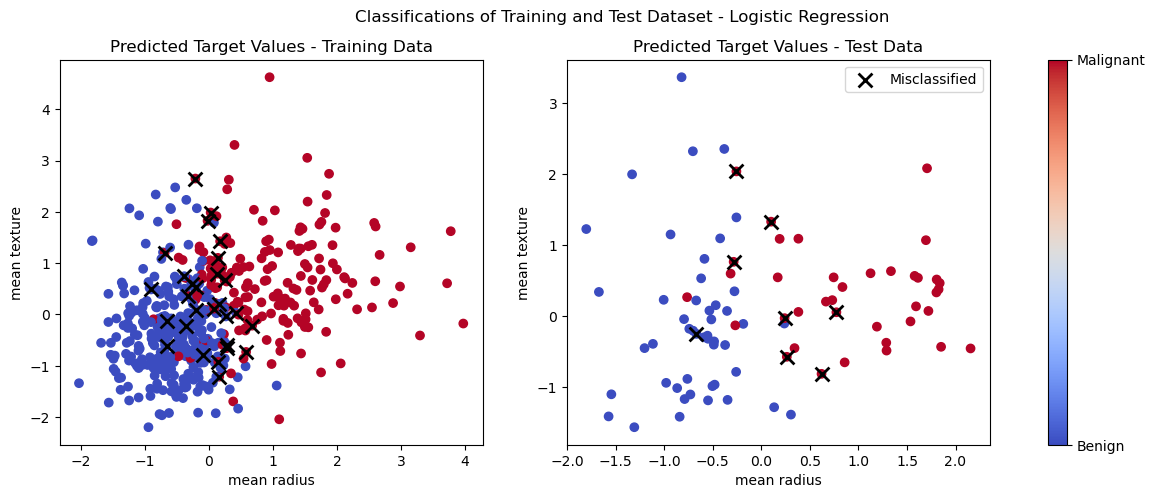

In [18]:
plotMisclassifiedPoints(X_train_scaled_df, y_train, X_test_scaled_df, y_test, "Classifications of Training and Test Dataset - Logistic Regression")

In the scatterplot above, it is evident that the model is not overfitting because there are instances where both false positives and false negatives occur. This indicates that the model's predictions are not overly biased towards either class, which is a desirable characteristic.

Furthermore, the plot reveals the presence of false positives, where some benign tumors are classified as malignant. This scenario is acceptable in the clinical setting because it emphasizes high recall, which means that the model correctly identifies the majority of malignant cases. In a medical context, it is crucial to minimize the number of malignant cases that are incorrectly classified as benign to ensure that potential cancer cases are not missed.

By prioritizing high recall, the model demonstrates its ability to identify most malignant tumors correctly, even if it results in some benign cases being misclassified as malignant. This trade-off is beneficial in a clinical setting, where early detection and accurate identification of malignant tumors are of utmost importance.

### Performance of Logistic Regression

In [19]:
def printAccuracyScore(tree_clf, title, X_train, y_train, X_test, y_test):
    print(f'Accuracy for Training Data ({title}): {round(tree_clf.score(X_train, y_train), 3)}')
    print(f'Accuracy for Test Data ({title}): {round(tree_clf.score(X_test, y_test), 3)}')


In [20]:
printAccuracyScore(log_reg, "Logistic Regression", X_train_scaled, y_train, X_test_scaled, y_test)

Accuracy for Training Data (Logistic Regression): 0.942
Accuracy for Test Data (Logistic Regression): 0.907


The accuracy values you provided indicate the performance of the logistic regression model on both the training and test data sets. 

An accuracy of 0.942 for the training data means that the logistic regression model correctly predicted the tumor status (malignant or benign) for approximately 94.2% of the samples in the training set. This indicates a good level of predictive performance on the data that the model was trained on.

An accuracy of 0.907 for the test data means that the logistic regression model correctly predicted the tumor status for approximately 90.7% of the samples in the test set. This suggests that the model generalizes well to unseen data and performs reasonably well on new, unseen samples.

Overall, an accuracy of 0.907 on the test data is quite good, indicating that the logistic regression model is able to make accurate predictions on new, unseen samples. However, it's important to note that accuracy alone may not provide a complete picture of model performance, especially if the classes in the dataset are imbalanced or if different types of errors (false positives vs. false negatives) have different consequences in the context of cancer diagnosis.

It is recommended to consider other evaluation metrics such as precision, recall, and F1-score, as well as analyzing the confusion matrix to gain a more comprehensive understanding of the model's performance and its ability to correctly classify malignant and benign tumors.

In [21]:
import numpy as np
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt

def drawConfusionMatrix(y_train, y_train_pred, y_test, y_test_pred, title):
# Define the class labels
    classes = ['benign', 'malignant']

    conf_matrix_train = confusion_matrix(y_train, y_train_pred)
    conf_matrix_test = confusion_matrix(y_test, y_test_pred)

    # Create the figure and axes objects
    fig, axs = plt.subplots(ncols=2, figsize=(15, 3))

    # Create the heatmap using matshow
    axs[0].matshow(conf_matrix_train, cmap=plt.cm.Blues)

    # Add colorbar to the heatmap
    # cbar = plt.colorbar(heatmap)

    # Set the ticks and labels for x and y axes
    axs[0].set_xticks(np.arange(len(classes)))
    axs[0].set_xticklabels(classes)
    axs[0].set_yticks(np.arange(len(classes)))
    axs[0].set_yticklabels(classes)

    # Add the count values to each cell
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = axs[0].text(j, i, conf_matrix_train[i, j],
                           ha="center", va="center", color="orange")

    # Set the title and axis labels
    axs[0].set_title(f'{title} - Training Data')
    axs[0].set_xlabel('Predicted Class')
    axs[0].set_ylabel('True Class')
    
    axs[1].matshow(conf_matrix_test, cmap=plt.cm.Blues)

    # Add colorbar to the heatmap
    # cbar = plt.colorbar(heatmap)

    # Set the ticks and labels for x and y axes
    axs[1].set_xticks(np.arange(len(classes)))
    axs[1].set_xticklabels(classes)
    axs[1].set_yticks(np.arange(len(classes)))
    axs[1].set_yticklabels(classes)

    # Add the count values to each cell
    for i in range(len(classes)):
        for j in range(len(classes)):
            text = axs[1].text(j, i, conf_matrix_test[i, j],
                           ha="center", va="center", color="orange")

    # Set the title and axis labels
    axs[1].set_title(f'{title} - Testing Data')
    axs[1].set_xlabel('Predicted Class')
    axs[1].set_ylabel('True Class')

    # Show the plot
    plt.show()

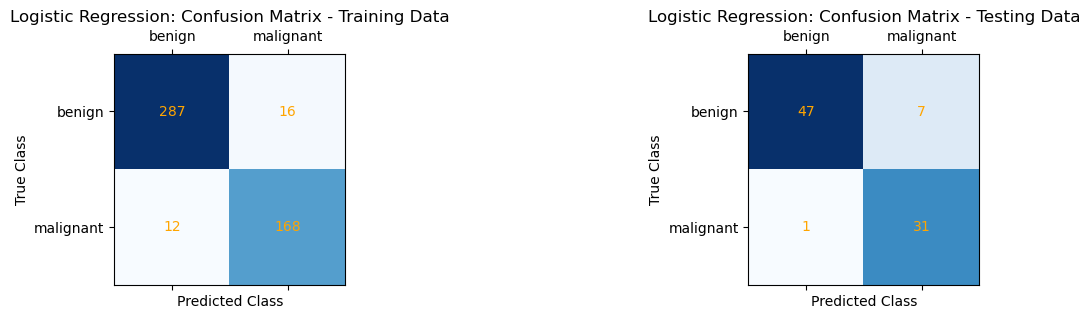

In [22]:
drawConfusionMatrix(y_train, y_train_pred, y_test, y_test_pred, 'Logistic Regression: Confusion Matrix')

In the test dataset, the logistic regression model exhibits a false negative where only one malignant case is misclassified as benign. However, it correctly identifies the majority of malignant cases. On the other hand, there are instances where benign tumors are predicted as malignant, totaling seven cases. Despite these false positives, which are benign tumors classified as malignant, the overall performance of the model is still considered acceptable for our specific setting.

Given the context of the problem, prioritizing high recall is crucial to ensure that malignant cases are not missed. Therefore, having only one false negative indicates that the model successfully identifies the majority of malignant tumors, reducing the risk of missing potentially cancerous cases.

While the presence of false positives (benign tumors classified as malignant) may cause some concern, it is considered acceptable in this setting. The focus is on minimizing false negatives and maximizing the identification of malignant cases. Therefore, the model's performance, with only one false negative and seven false positives, can still be considered satisfactory for the given clinical application.

In [23]:
from sklearn.metrics import precision_score, recall_score

def printPerformanceMetrics(y_train, y_train_pred, y_test, y_test_pred, tree_type):
    precision_test = precision_score(y_test, y_test_pred)
    recall_test = recall_score(y_test, y_test_pred)
    
    precision_train = precision_score(y_train, y_train_pred)
    recall_train = recall_score(y_train, y_train_pred)    

    print(f"Precision - {tree_type} (Training Dataset): {round( precision_train, 3)}")
    print(f"Recall - {tree_type} (Training Dataset): { round( recall_train, 3) }")    
    print('\n')    
    print(f"Precision - {tree_type} (Test Dataset): {round( precision_test, 3)}")
    print(f"Recall - {tree_type} (Test Dataset): { round( recall_test, 3)}")

In [24]:
printPerformanceMetrics(y_train, y_train_pred, y_test, y_test_pred, "Logistic Regression")

Precision - Logistic Regression (Training Dataset): 0.913
Recall - Logistic Regression (Training Dataset): 0.933


Precision - Logistic Regression (Test Dataset): 0.816
Recall - Logistic Regression (Test Dataset): 0.969


Based on the provided statistics, here is the conclusion regarding the performance of the logistic regression model on both the training and test datasets:

Training Dataset:
- Precision: 0.913
- Recall: 0.933
- Accuracy: 0.942

The model achieves a high precision of 0.913, indicating that when it predicts a tumor as malignant or benign, it is correct approximately 91.3% of the time. The recall value of 0.933 suggests that the model is able to correctly identify approximately 93.3% of the malignant tumors in the training dataset. The accuracy of 0.942 demonstrates the overall predictive performance on the training data, indicating that the model is accurate for approximately 94.2% of the samples.

Test Dataset:
- Precision: 0.816
- Recall: 0.969
- Accuracy: 0.907

On the test dataset, the precision value of 0.816 indicates that when the model predicts a tumor as malignant or benign, it is correct around 81.6% of the time. The recall value of 0.969 suggests that the model is able to correctly identify approximately 96.9% of the malignant tumors in the test dataset. The accuracy of 0.907 shows the overall predictive performance on the unseen test data, indicating that the model is accurate for approximately 90.7% of the samples.

Overall, the logistic regression model demonstrates good performance on both the training and test datasets, with high accuracy values indicating its ability to generalize well to new, unseen samples. The model shows reasonably high precision and recall values, indicating its effectiveness in correctly classifying both malignant and benign tumors.


## Decision Tree

### Tuning hyperparameters for Decision Tree

When using a Decision Tree Classifier, the choice of hyperparameters can significantly impact its performance. In this case, the hyperparameters being tuned are 'max_depth', 'min_samples_split', and 'min_samples_leaf'. The goal is to find the optimal combination of these hyperparameters that maximizes the F1 score.

The 'max_depth' hyperparameter determines the maximum depth of the decision tree. A higher value allows the tree to have more levels and capture more complex relationships in the data. However, setting it too high can lead to overfitting, where the model becomes too specific to the training data and performs poorly on new, unseen data. 

The 'min_samples_split' hyperparameter sets the minimum number of samples required to split an internal node. It helps control the stopping criteria for further splitting. Setting a higher value prevents the tree from splitting nodes that have fewer samples, which can reduce overfitting and increase generalization. 

The 'min_samples_leaf' hyperparameter determines the minimum number of samples required to be at a leaf node. It helps control the granularity of the tree by setting a threshold for stopping further splitting.

The scoring metric used to evaluate the performance of the model and select the optimal hyperparameters is the F1 score. The F1 score is a measure that combines precision and recall, providing a balanced assessment of the model's ability to classify both malignant and benign tumors. Since we aim for high precision and high recall, the F1 score is a suitable metric for optimizing the hyperparameters of the Decision Tree Classifier.

By tuning the hyperparameters using the provided ranges and evaluating the F1 score, we can identify the combination of hyperparameters that achieves the best trade-off between precision and recall, ensuring that the decision tree model performs well in classifying the tumor status.


In [25]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier
tree_clf = DecisionTreeClassifier(random_state=123)

# Define the hyperparameters to be tuned and their possible values
parameters = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
}

# Create a GridSearchCV object with 3-fold cross-validation
clf = GridSearchCV(tree_clf, parameters, cv=5, scoring='f1')

# Fit the GridSearchCV object to the training data
clf.fit(X_train, y_train)

# Print the best hyperparameters and their corresponding score
print('Best hyperparameters:', clf.best_params_)
print('Best F1 score:', round(clf.best_score_, 2))

Best hyperparameters: {'max_depth': 5, 'min_samples_leaf': 1, 'min_samples_split': 4}
Best F1 score: 0.87


The optimal hyperparameters for the Decision Tree Classifier were determined using cross-validation and Grid Search. After evaluating multiple combinations of hyperparameters, the best combination was found to be:

- max_depth: 5
- min_samples_leaf: 1
- min_samples_split: 4

The max_depth of 5 indicates that the decision tree can have a maximum depth of 5 levels. This helps control the complexity of the tree and prevent overfitting. The min_samples_leaf value of 1 means that each leaf node must have at least 1 sample, ensuring that the tree can capture individual samples. The min_samples_split of 4 specifies that a node should not be split further if it contains fewer than 4 samples. This parameter helps prevent excessive splitting and ensures that there are enough samples in each split to make reliable decisions.

The chosen hyperparameters aim to balance precision and generalization. The min_samples_split value of 4 ensures that there are enough samples in each split to make accurate predictions, while the min_samples_leaf value of 1 allows the tree to capture individual samples and make precise decisions. The max_depth value of 5 controls the complexity of the tree, striking a balance between capturing important patterns and avoiding overfitting.

The model achieved a best F1 score of 0.87, which indicates a good balance between precision and recall. The F1 score takes into account both the precision and recall metrics, providing an overall measure of the model's performance.

Overall, the chosen hyperparameters and the achieved F1 score indicate that the Decision Tree Classifier is capable of effectively classifying the tumor status, balancing precision and recall, and making reliable predictions.

### Traninng Decision Tree Classifier with optimal hyperparameters

As the decision tree algorithm is not sensitive to feature scaling, we can directly use the X_train data without any scaling for training our decision tree classifier. This means that we can work with the original feature values without the need for normalization or standardization.

In [26]:
tree_clf_opt = DecisionTreeClassifier(random_state=5, max_depth=5, min_samples_leaf=1, min_samples_split=4)
tree_clf_opt.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_split=4, random_state=5)

In [27]:
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    tree_clf_opt,
    out_file='tree_clf_opt.dot',
    feature_names=X.columns,
    class_names=['Benign', 'Malignant'],
    filled=True,
    rounded=True,
 
)
src = Source.from_file('tree_clf_opt.dot')


src.render('tree_clf_opt', format='png', cleanup=True, view=True) 

'tree_clf_opt.png'

As shown in the diagram above, we constructed a decision tree with a depth of 5.

To classify a new tumor cell using the decision tree model, the process begins at the root node (depth=0) by evaluating whether the mean radius value of the tumor cell is less than or equal to 15.025. If this condition is satisfied, the model proceeds to the left node (depth=1) and examines the compactness mean, determining if it is less than or equal to 0.125. This process continues as the model traverses the tree, evaluating different features and thresholds at each node until a final classification is reached for the cell.

In [28]:
y_train_pred = tree_clf_opt.predict(X_train)
y_test_pred = tree_clf_opt.predict(X_test)

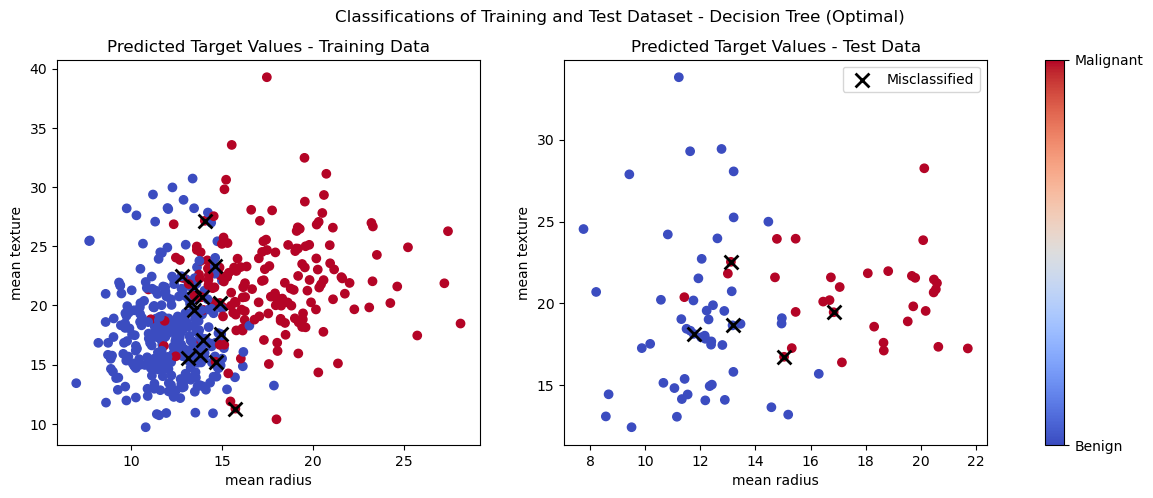

In [29]:
plotMisclassifiedPoints(X_train, y_train, X_test, y_test, "Classifications of Training and Test Dataset - Decision Tree (Optimal)")

In comparison to the logistic regression model, the decision tree model tends to have a lower number of misclassifications in its predictions which can be observed in the scatterplot above

### Performance of Decision Tree

In [30]:
printAccuracyScore(tree_clf_opt, "Decision Tree", X_train, y_train, X_test, y_test)

Accuracy for Training Data (Decision Tree): 0.971
Accuracy for Test Data (Decision Tree): 0.942


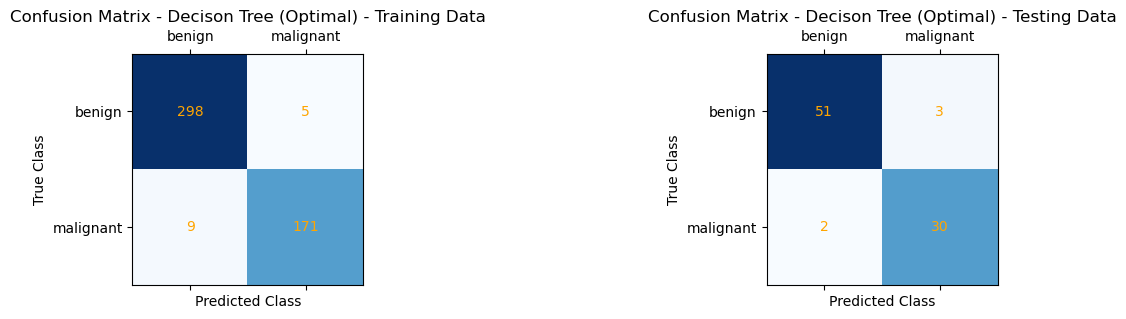

In [31]:
drawConfusionMatrix(y_train, y_train_pred, y_test, y_test_pred, "Confusion Matrix - Decison Tree (Optimal)")

In [32]:
printPerformanceMetrics(y_train, y_train_pred, y_test, y_test_pred, "Decision Tree (Optimal)")

Precision - Decision Tree (Optimal) (Training Dataset): 0.972
Recall - Decision Tree (Optimal) (Training Dataset): 0.95


Precision - Decision Tree (Optimal) (Test Dataset): 0.909
Recall - Decision Tree (Optimal) (Test Dataset): 0.938


These results indicate the performance of the decision tree model on both the training and test datasets. 

For the training dataset:
- Precision of 0.972 means that out of the instances predicted as positive (e.g., malignant), 97.2% were actually positive.
- Recall of 0.95 means that out of all the actual positive instances in the dataset, 95% were correctly identified by the model.

For the test dataset:
- Precision of 0.909 means that out of the instances predicted as positive, 90.9% were actually positive.
- Recall of 0.938 means that out of all the actual positive instances in the test dataset, 93.8% were correctly identified by the model.

These metrics provide insights into the accuracy and performance of the decision tree model. A higher precision indicates that the model has a lower false positive rate, while a higher recall suggests a lower false negative rate. It is important to strike a balance between precision and recall based on the specific requirements of the problem at hand.

## Summary and Recommendation

 Here's a table summarizing the performance metrics for the logistic regression and decision tree models on both the training and test datasets:

| Model                     | Precision (Training) | Recall (Training) | Accuracy (Training) | Precision (Test) | Recall (Test) | Accuracy (Test) |
|---------------------------|---------------------|------------------|---------------------|------------------|---------------|-----------------|
| Logistic Regression       | 0.913               | 0.933            | 0.942               | 0.816            | 0.969         | 0.907           |
| Decision Tree (Optimal)   | 0.972               | 0.95             | 0.971               | 0.909            | 0.938         | 0.942           |

This table presents the precision, recall, and accuracy metrics for both models on the training and test datasets. The higher the values for precision, recall, and accuracy, the better the model's performance.

**Recommendation:**

Based on the provided metrics, the decision tree model (optimal) demonstrates slightly better performance across most evaluation metrics compared to logistic regression. It exhibits higher precision, recall, and accuracy on both the training and test datasets.

Therefore, in a clinical setting, the decision tree model would be more appropriate for tumor cell classification. Its higher precision indicates a lower false positive rate, which is crucial in healthcare to minimize misdiagnoses of malignant cells as benign. Additionally, its higher recall indicates a lower false negative rate, ensuring that fewer actual malignant cells are missed during classification.

However, it is essential to consider other factors such as interpretability and explainability. Decision tree models are often more interpretable due to their tree-like structure, which can help clinicians understand the decision-making process and contribute to trust in the model's predictions.

**Therefore, based on the superior performance and interpretability, the decision tree model (optimal) is recommended for tumor cell classification in a clinical setting.**

## Feature Importance

### Logistic Regression

To identify the features that have a higher chance of impacting the prediction of the tumor status according to each of the two models, we can analyze the feature importances provided by the models. 

For the logistic regression model, we can access the coefficients of the trained model to understand the impact of each feature. The magnitude of the coefficients indicates the strength of the relationship between each feature and the predicted outcome. Larger coefficients indicate a stronger impact on the prediction. Positive coefficients indicate a positive relationship with the target variable (malignant tumor), while negative coefficients indicate a negative relationship (benign tumor).

In [33]:
# Get the feature coefficients
feature_coefficients = pd.DataFrame({'Feature': X_train.columns, 'Coefficient': log_reg.coef_[0]})

# Sort the coefficients by magnitude
sorted_coefficients = feature_coefficients.sort_values(by='Coefficient', ascending=False)

# Print the top features with higher impact
print("Top features impacting prediction according to Logistic Regression:")
print(sorted_coefficients)

Top features impacting prediction according to Logistic Regression:
                  Feature  Coefficient
0             radius_mean     4.404674
1            texture_mean     1.721787
2         smoothness_mean     1.189852
3        compactness_mean     0.971313
4           symmetry_mean     0.619969
5  fractal_dimension_mean    -0.208488


Logistic regression coefficients indicate the impact of features on predictions. According to the coefficients provided:

1. Higher radius mean strongly predicts a positive outcome (e.g., malignant tumor).
2. Higher texture mean is also associated with a positive outcome.
3. Increased smoothness and compactness moderately contribute to a positive outcome.
4. Higher symmetry mean suggests a higher likelihood of a positive outcome.
5. Increased fractal dimension mean is linked to a decreased probability of a positive outcome.

### Decision Tree Model

For the decision tree model, we can analyze the feature importances derived from the tree structure. The feature importances represent the relative importance of each feature in the decision-making process of the tree. Higher importances indicate a stronger impact on the prediction. The feature importances are calculated based on how much each feature reduces the impurity in the dataset when making decisions at each node of the tree.

In [34]:
# Get the feature importances
feature_importances = pd.DataFrame({'Feature': X_train.columns, 'Importance': tree_clf_opt.feature_importances_})

# Sort the importances in descending order
sorted_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print the top features with higher impact
print("Top features impacting prediction according to Decision Tree:")
print(sorted_importances)

Top features impacting prediction according to Decision Tree:
                  Feature  Importance
0             radius_mean    0.717875
3        compactness_mean    0.131801
1            texture_mean    0.093478
2         smoothness_mean    0.031173
4           symmetry_mean    0.025673
5  fractal_dimension_mean    0.000000


In a decision tree, feature importance represents the relative significance of each feature in making predictions. The higher the importance value, the greater the impact of the feature on the prediction. The importance values are typically normalized, summing up to 1. Based on the given feature importances, the top features impacting the prediction outcome according to the decision tree are as follows:

1. Radius Mean: This feature has the highest importance value (0.717875), indicating that it plays a significant role in determining the prediction outcome.

2. Compactness Mean: With an importance value of 0.131801, the compactness of the tumor is the second most influential feature.

3. Texture Mean: The importance value of 0.093478 suggests that texture also contributes to the prediction outcome, although to a lesser extent compared to radius mean and compactness mean.

4. Smoothness Mean: This feature has an importance value of 0.031173, indicating a relatively lower impact on the prediction compared to the previous features.

5. Symmetry Mean: The importance value of 0.025673 suggests that symmetry has a minor influence on the prediction outcome.

6. Fractal Dimension Mean: The importance value of 0.000000 indicates that this feature is not considered relevant by the decision tree for making predictions.

When dealing with high cardinality features, impurity-based feature importances can be misleading. In such cases, it's recommended to use permutation importance as an alternative method. Here's an updated code snippet for the decision tree model using permutation importance:

In [35]:
from sklearn.inspection import permutation_importance

# Calculate permutation importances
result = permutation_importance(tree_clf_opt, X_test, y_test, n_repeats=10, random_state=123)

# Get the feature importances and their standard deviations
feature_importances = pd.DataFrame({'Feature': X_test.columns, 'Importance': result.importances_mean, 'Std Dev': result.importances_std})

# Sort the importances in descending order
sorted_importances = feature_importances.sort_values(by='Importance', ascending=False)

# Print the top features with higher impact
print("Top features impacting prediction according to Decision Tree (Permutation Importance):")
print(sorted_importances.head(10))


Top features impacting prediction according to Decision Tree (Permutation Importance):
                  Feature  Importance   Std Dev
0             radius_mean    0.287209  0.045349
1            texture_mean    0.059302  0.019767
3        compactness_mean    0.031395  0.017286
2         smoothness_mean    0.020930  0.010137
4           symmetry_mean    0.019767  0.012791
5  fractal_dimension_mean    0.000000  0.000000


The provided feature importances are based on the Permutation Importance method applied to a decision tree model. Permutation Importance measures the change in model performance when randomly permuting the values of a specific feature while keeping other features unchanged. A higher importance value indicates a stronger impact of the feature on the model's predictions.

Based on the given importances, the top features impacting the prediction outcome according to the Permutation Importance method in the decision tree model are as follows:

1. Radius Mean: This feature has the highest importance value (0.287209) and exhibits the most significant impact on the model's predictions.

2. Texture Mean: With an importance value of 0.059302, texture contributes to the model's predictions, albeit to a lesser extent compared to radius mean.

3. Compactness Mean: This feature has an importance value of 0.031395, indicating a moderate impact on the model's predictions.

4. Smoothness Mean: With an importance value of 0.020930, smoothness is relatively less impactful on the model's predictions compared to the previous features.

5. Symmetry Mean: The importance value of 0.019767 suggests that symmetry has a minor influence on the model's predictions.

6. Fractal Dimension Mean: The importance value of 0.000000 indicates that this feature is not considered relevant by the decision tree model when using the Permutation Importance method.

Additionally, the standard deviation values provided (Std Dev) represent the variability or uncertainty in the importance estimates for each feature.


### Similarities/Dissimilarities

Similarities:
- Both logistic regression and decision tree analysis identify important features that impact the prediction outcome.
- In both models, the top features identified include `radius_mean`, `compactness_mean`, `texture_mean` and `smoothness_mean`.
- The rankings of the `radius_mean` has the highest coefficient in logistic regression, while `radius_mean` has the highest importance in the decision tree.

Differences:
- Logistic regression provides the coefficients that indicate the strength and direction of the impact, while decision tree analysis provides importance values that represent the relative significance of the features.
- The coefficient values in logistic regression indicate the magnitude of the effect, whereas importance values in decision trees represent the relative importance within the model.
- The rankings of the features differ between the two models. For example, `texture mean` and `smoothness mean` has the highest coefficient in logistic regression, while `compactness mean `and `texture mean` has the highest importance in the decision tree after radius mean in both model.
- Logistic regression allows for a more quantitative interpretation of feature impact based on the coefficient values, while decision trees provide a more qualitative understanding through importance values and feature splits.

Overall, both logistic regression and decision tree analysis help identify important features, but they differ in terms of the interpretation and methodology used to determine feature impact.

## PCA 

### Variances explained by principal components

Since PCA is sensitive to data scaling, we will use scaled data 

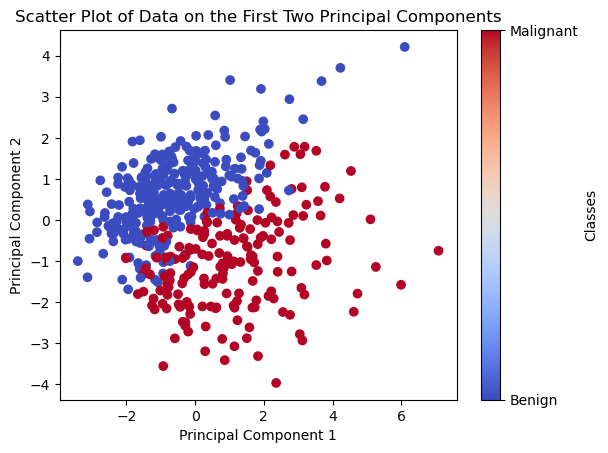

Proportion of Data Variance explained by Principal Component 1:  0.46
Proportion of Data Variance explained by Principal Component 2:  0.26
Proportion of Data Variance Explained by the First Two Principal Components: 0.73


In [36]:
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Apply PCA with two components
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_scaled)

# Scatter plot of the data on the first two principal components
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm')
plt.xlabel('Principal Component 1')
plt.ylabel('Principal Component 2')
plt.title('Scatter Plot of Data on the First Two Principal Components')
cbar = plt.colorbar(ticks=[0, 1])
cbar.set_label('Classes')
cbar.set_ticklabels(['Benign', 'Malignant'])
plt.show()

# Proportion of data variance explained by the first two principal components
explained_variance_ratio = pca.explained_variance_ratio_
variance_explained = sum(explained_variance_ratio[:2])

print("Proportion of Data Variance explained by Principal Component 1: ", round(explained_variance_ratio[0], 2))
print("Proportion of Data Variance explained by Principal Component 2: ", round(explained_variance_ratio[1], 2))
print("Proportion of Data Variance Explained by the First Two Principal Components:", round(variance_explained, 2))

The provided information pertains to Principal Component Analysis (PCA), which is a dimensionality reduction technique. It involves transforming the original variables into a new set of uncorrelated variables called principal components. 

The interpretation of the given information is as follows:

- Proportion of Data Variance explained by Principal Component 1: 0.46. This means that the first principal component captures 46% of the total variance present in the original data. It represents the direction of maximum variation in the data.

- Proportion of Data Variance explained by Principal Component 2: 0.26. The second principal component accounts for an additional 26% of the total variance in the data. It captures the second largest source of variation orthogonal to the first principal component.

- Proportion of Data Variance Explained by the First Two Principal Components: 0.73. When considering both the first and second principal components, they together explain 73% of the total variance present in the original dataset. This cumulative variance explains the majority of the information in the data, providing a good representation of the underlying structure.

### Biplot with the variables vectors and the projected data

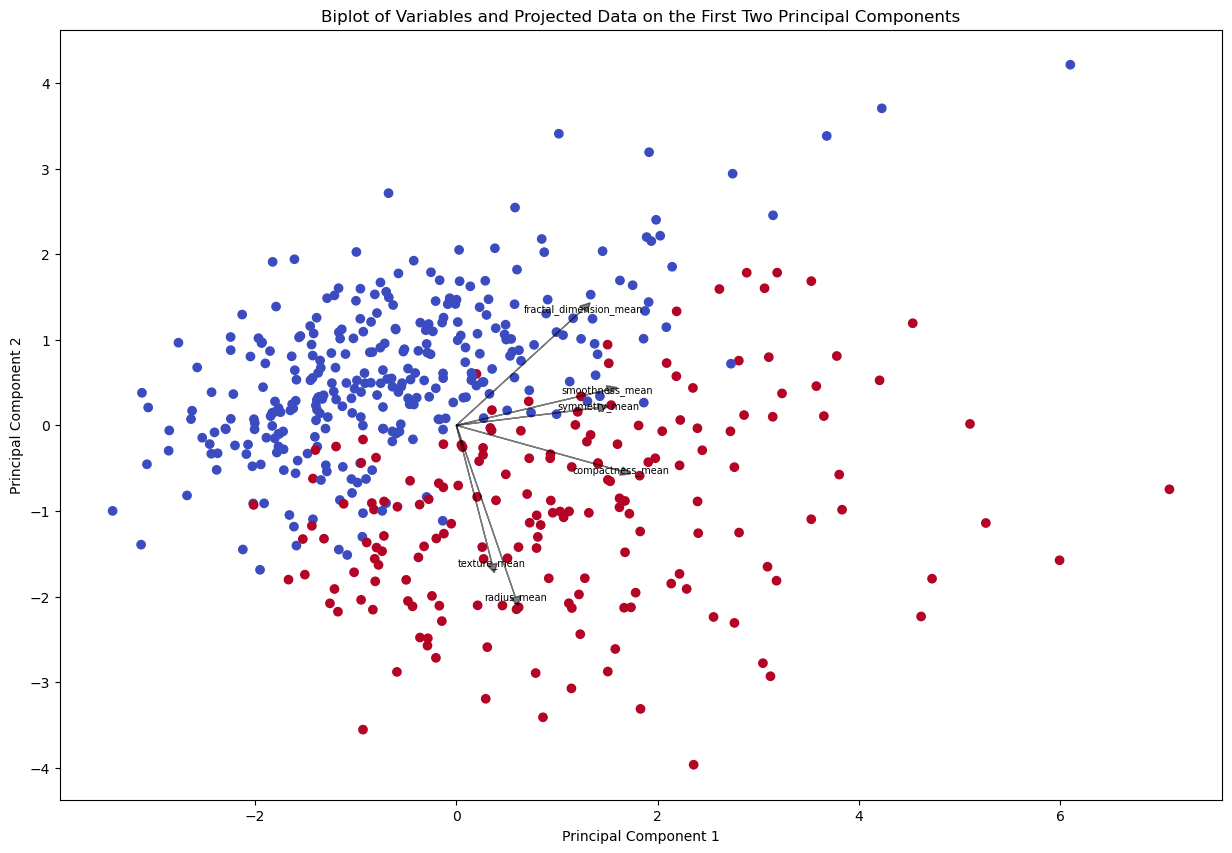

In [37]:
# Step 1: Import necessary libraries
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.preprocessing import LabelEncoder

# Step 2: Create the biplot
fig, ax = plt.subplots(figsize=(15,10))
ax.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='coolwarm')
ax.set_xlabel('Principal Component 1')
ax.set_ylabel('Principal Component 2')
ax.set_title('Biplot of Variables and Projected Data on the First Two Principal Components')

# Plot variable vectors as arrows
feature_vectors = pca.components_.T
scale_factor = 3  # Adjust the scaling factor as needed
for i, feature in enumerate(X.columns):
    ax.arrow(0, 0, scale_factor * feature_vectors[i, 0], scale_factor * feature_vectors[i, 1], color='black', alpha=0.5, head_width=0.1, head_length=0.1)
    ax.text(scale_factor * feature_vectors[i, 0], scale_factor * feature_vectors[i, 1], feature, color='black', ha='center', va='center', fontsize=7)

plt.show()

To interpret the biplot and determine the variables related to the tumor status:

1. Direction: The direction of the feature vectors (arrows) in the biplot indicates the relationship between the variables and tumor status. Variables that align closely with the tumor status categories (Malignant and Benign) are more strongly associated with the tumor status. In the given biplot, `radius mean`, `texture mean`, and `compactness mean` are aligned towards the Malignant category, indicating their strong association with malignant tumors.

2. Proximity: The proximity of the feature vectors to the tumor status categories reflects the strength of the relationship between variables and tumor status. Variables located closer to a specific category are more influential in determining the tumor status. In the biplot, `radius mean`, `texture mean`, and `compactness mean` are closer to the Malignant category, indicating their higher impact on determining malignant tumors. On the other hand, `fractal dimension mean` is closer to the Benign category, suggesting its stronger association with benign tumors.

By considering the direction and proximity of the feature vectors in the biplot, we can identify which variables are more related to the tumor status and contribute significantly to distinguishing between malignant and benign tumors.

### Comparison with feature importance

When comparing the results obtained from Task 2 (Logistic Regression and Decision Tree) with the results from Task 4 (biplot), we can observe the following:

1. Common Features: Both Logistic Regression and Decision Tree models identified `radius_mean`, `texture_mean`, `compactness_mean` as important features in predicting tumor status.

2. Differences in Importance: The importance or coefficient values assigned to these features differ between the models. In Logistic Regression, the coefficients indicate the strength and direction of the impact, whereas in Decision Tree, the importance represents the relative significance. For example, `radius_mean` has the highest coefficient in Logistic Regression, while it has the highest importance in Decision Tree.

3. Permutation Importance: The Decision Tree model with permutation importance provides additional insights into the variability and uncertainty of feature importance. It includes standard deviation values, indicating the spread of importance values for each feature.

4. Biplot Interpretation: The biplot analysis offers a visual representation of feature relationships and their association with tumor status. It reveals the direction and proximity of the feature vectors to the Malignant and Benign categories, providing insights into the variables' strength of association with each category.

Overall, while Logistic Regression and Decision Tree provide quantitative measures of feature importance, the biplot analysis adds a visual interpretation of the relationships between variables and tumor status. The combination of both approaches can offer a more comprehensive understanding of the important features in predicting tumor status.

### PCA to explain 95% of the variance

By setting the `n_components` parameter to 0.95 in PCA, we aim to select the minimum number of principal components that collectively explain 95% of the variance present in the entire dataset. The selected principal components capture the most significant patterns and variability in the data while reducing the dimensionality of the feature space.

In [38]:
pca = PCA(n_components=0.95)
X_train_reduced = pca.fit_transform(X_train_scaled)
X_test_reduced = pca.transform(X_test_scaled)

In [39]:
print("Dimension of the new (projected) data set:", X_train_reduced.shape[1])

Dimension of the new (projected) data set: 5


After performing PCA and selecting the appropriate number of components to retain 95% of the explained variance, the dimension of the new (projected) dataset is reduced to 5. This means that the original set of features has been transformed into a lower-dimensional space represented by five principal components that capture the most important information from the original features while reducing the feature space. The original feature space consisted of 6 features. 

We will train a new decision tree model with the intention of improving its performance compared to the previous model. The decision tree model is specifically chosen due to its explanatory nature, enabling us to comprehend and interpret the decision-making process involved in each split and decision made by the model. This transparency offers valuable insights into how the model utilizes the reduced dimensionality features obtained through PCA and how it relates them to predicting the tumor status. Moreover, the decision tree model has exhibited superior performance compared to logistic regression in our previous analysis. By selecting the decision tree model, we aim to achieve the best overall model performance by accurately predicting the tumor status. The decision tree's capability to capture complex relationships and interactions among the features grants it an advantage over logistic regression in this specific task, making it a promising candidate for achieving optimal results.

#### Tuning hyperparameters for new Decision Tree

Similar to the approach used previously, we will employ a similar methodology to find the optimal parameters for the new decision tree model. In this case, we will focus on tuning the parameters to maximize the F1 score, which is a suitable scoring measure for evaluating the model's performance in our classification task

In [40]:
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier

# Create a decision tree classifier
tree_clf = DecisionTreeClassifier(random_state=123)

# Define the hyperparameters to be tuned and their possible values
parameters = {
    'max_depth': [2, 3, 4, 5, 6, 7, 8],
    'min_samples_split': [2, 3, 4, 5, 6, 7, 8, 9, 10],
    'min_samples_leaf': [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15]
}

# Create a GridSearchCV object with 3-fold cross-validation
clf = GridSearchCV(tree_clf, parameters, cv=5, scoring='f1')

# Fit the GridSearchCV object to the training data
clf.fit(X_train_reduced, y_train)

# Print the best hyperparameters and their corresponding score
print('Best hyperparameters:', clf.best_params_)
print('Best F1 score:', round(clf.best_score_, 2))

Best hyperparameters: {'max_depth': 5, 'min_samples_leaf': 2, 'min_samples_split': 10}
Best F1 score: 0.88


#### Training Decision Tree with reduced dimensions

In [41]:
tree_clf_pca = DecisionTreeClassifier(random_state=5, max_depth=5, min_samples_leaf=2, min_samples_split=10)
tree_clf_pca.fit(X_train_reduced, y_train)

DecisionTreeClassifier(max_depth=5, min_samples_leaf=2, min_samples_split=10,
                       random_state=5)

In [42]:
from sklearn.tree import export_graphviz
from graphviz import Source

export_graphviz(
    tree_clf_pca,
    out_file='tree_clf_pca.dot',
    class_names=['Benign', 'Malignant'],
    filled=True,
    rounded=True,
 
)
src = Source.from_file('tree_clf_pca.dot')
src.render('tree_clf_pca', format='png', cleanup=True, view=True) 

'tree_clf_pca.png'

The decision tree utilizes the new projected feature set, derived from the application of PCA, to make decisions. This can be observed in the decision tree diagram, where the nodes and branches represent the features and their respective thresholds used for splitting the data. By using the reduced dimensionality features obtained through PCA, the decision tree incorporates the most significant information from the original features, enabling it to effectively make decisions and classify instances based on the tumor status.

#### Performance of Decision Tree (PCA)

In [43]:
y_train_pred = tree_clf_pca.predict(X_train_reduced)
y_test_pred = tree_clf_pca.predict(X_test_reduced)

In [44]:
printAccuracyScore(tree_clf_pca, "Decision Tree - PCA", X_train_reduced, y_train, X_test_reduced, y_test)

Accuracy for Training Data (Decision Tree - PCA): 0.963
Accuracy for Test Data (Decision Tree - PCA): 0.907


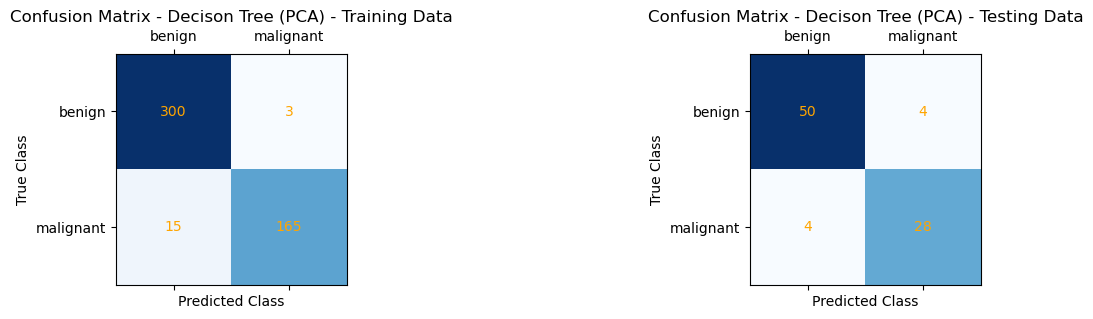

In [45]:
drawConfusionMatrix(y_train, y_train_pred, y_test, y_test_pred, "Confusion Matrix - Decison Tree (PCA)")

In [46]:
printPerformanceMetrics(y_train, y_train_pred, y_test, y_test_pred, "Decision Tree (PCA)")

Precision - Decision Tree (PCA) (Training Dataset): 0.982
Recall - Decision Tree (PCA) (Training Dataset): 0.917


Precision - Decision Tree (PCA) (Test Dataset): 0.875
Recall - Decision Tree (PCA) (Test Dataset): 0.875


Sure! Here's a table summarizing the performance metrics for the decision tree model trained on PCA-transformed features and the decision tree model with optimal parameters, along with the corresponding metrics for both the training and test datasets:

| Model                           | Accuracy (Training) | Accuracy (Test) | Precision (Training) | Precision (Test) | Recall (Training) | Recall (Test) |
|---------------------------------|---------------------|----------------|----------------------|------------------|-------------------|---------------|
| Decision Tree (PCA - Reduced Feature space)             | 0.963               | 0.907          | 0.982                | 0.875            | 0.917             | 0.875         |
| Decision Tree (Original Feature Space)         | 0.971               | 0.942          | 0.972                | 0.909            | 0.950             | 0.938         |

From the provided data, we can observe the following:

Based on the provided data, it can be observed that the Decision Tree model trained on the original feature space outperforms the Decision Tree model trained on the reduced feature space obtained through PCA. The Decision Tree with original features achieves higher precision, recall, and accuracy values for both the training and test datasets. This indicates that the model utilizing the original features provides better results in terms of correctly identifying positive instances, capturing true positive instances, and overall prediction accuracy. Therefore, it can be concluded that using the original features instead of the principal components resulted in improved performance in this particular scenario.

#### Conclusion


There are several potential reasons for the superior performance of the Decision Tree trained on the original feature space compared to the Decision Tree with PCA:

1. Information preservation: The Decision Tree trained on the original feature space directly utilizes all the information present in the original features. In contrast, PCA reduces the dimensionality of the data by transforming it into principal components, potentially leading to information loss. By using the original features, the Decision Tree trained on the original feature space can better capture the nuances and relationships present in the data.

2. Enhanced feature relevance: PCA selects principal components based on their ability to explain the variance in the data, without considering their specific relationship with the target variable. This can result in the inclusion of less relevant features in the reduced feature space. In contrast, the Decision Tree trained on the original feature space directly considers the features that are more directly associated with the target variable, potentially leading to improved performance.

3. Non-linear relationships: Decision Trees excel at capturing non-linear relationships between features and the target variable. However, PCA applies a linear transformation to the data, potentially missing out on complex non-linear relationships. By using the original feature space, the Decision Tree can better capture and exploit the non-linear relationships present in the data.

4. Avoiding noise in principal components: The process of computing principal components involves the covariance matrix of the original features. If the data contains noise or irrelevant features, this noise can propagate into the principal components. This noise may negatively impact the performance of the Decision Tree with PCA. In contrast, the Decision Tree trained on the original feature space avoids this potential issue by directly working with the original, potentially less noisy features.

5. Overfitting with PCA: By reducing the dimensionality of the data, PCA can introduce bias and potentially overfit the training data. This may result in decreased generalization performance on the test data. In contrast, the Decision Tree trained on the original feature space does not suffer from this issue and can better generalize to unseen data.

In summary, the Decision Tree trained on the original feature space likely outperforms the Decision Tree with PCA due to the preservation of information, enhanced feature relevance, better capturing of non-linear relationships, avoiding noise in principal components, and mitigating overfitting issues.

# A clustering analysis on airlines safety records

Our study aims to cluster airlines based on their safety records, providing travelers with valuable insights to make informed decisions about airline choices. By analyzing data and applying clustering techniques, we will identify patterns and similarities among airlines, enabling individuals to better understand the safety performance of different airlines. Our focus is on empowering travelers with educational insights for making informed decisions based on safety considerations.

**Assumptions:** (From the website)

1. All crashes, regardless of their cause, are included in the analysis.
2. The number of available seat kilometers (ASKs) is taken as of December 2012, assuming a constant ASK figure for each airline since 1985. This assumption is made for simplicity until older data becomes available.
3. Airlines that were not operational as of January 1, 1985, are excluded from the analysis.
4. Major mergers are accounted for by combining the data of merged airlines (e.g., Northwest and Delta).
5. Data for regional subsidiaries is included under the flagship carrier (e.g., American Eagle incidents are grouped with American Airlines data).

These assumptions provide a framework for the analysis, considering the available data and addressing certain simplifications necessary for the study.

## Exploring Dataset

In [47]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Load the dataset
data = pd.read_csv('airline-safety.csv')
data.head()

,airline,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,Aer Lingus,320906734,2,0,0,0,0,0
1,Aeroflot*,1197672318,76,14,128,6,1,88
2,Aerolineas Argentinas,385803648,6,0,0,1,0,0
3,Aeromexico*,596871813,3,1,64,5,0,0
4,Air Canada,1865253802,2,0,0,2,0,0


Since the K-means algorithm relies on numerical input for clustering analysis, text data cannot be directly used. Therefore it is appropriate to exclude the airline names from the dataset as they are non-numerical and may not contribute significantly to the clustering process. By removing this column, we can focus solely on the numerical variables related to safety records, allowing for a more effective identification of similarities and patterns among airlines based on their safety performance.

In [48]:
X = data.drop('airline', axis=1)

To ensure accurate clustering results, it is necessary to address the differing units of the variables in the dataset. Scaling the data is essential as K-means clustering can be influenced by the magnitude of the features. By applying scaling techniques, such as standardization or normalization, we can bring all variables to a comparable scale, eliminating any potential bias in the clustering process. This step enhances the reliability of the clustering analysis and allows for a more meaningful interpretation of the results.

In [49]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_scaled = std_scaler.fit_transform(X)

By scaling the variables, I transformed them to a similar scale or range, preventing any single variable from dominating the clustering analysis due to its larger scale. This allowed me to obtain meaningful and balanced clusters based on the true patterns and relationships in the data.

In [50]:
X_scaled_df = pd.DataFrame(X_scaled, columns=X.columns)
X_scaled_df.head()

,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14
0,-0.732498,-0.473505,-0.768345,-0.773244,-0.915809,-0.776414,-0.503179
1,-0.128737,6.292717,4.169215,0.107235,0.416277,0.398699,0.294398
2,-0.687808,-0.107763,-0.768345,-0.773244,-0.693795,-0.776414,-0.503179
3,-0.542462,-0.382069,-0.415662,-0.333005,0.194263,-0.776414,-0.503179
4,0.330974,-0.473505,-0.768345,-0.773244,-0.471780,-0.776414,-0.503179


## Visualization of Dataset

By visualizing the data in a scatter plot, we can gain insights into the patterns and relationships within the dataset. This visualization allows us to observe the distribution and potential clusters formed by the data points. By examining the plot, we can identify any discernible groupings or trends, which can provide initial indications of similarities or differences in the safety records of the airlines. This visualization serves as a starting point for further analysis and can guide the subsequent steps of clustering and interpretation.

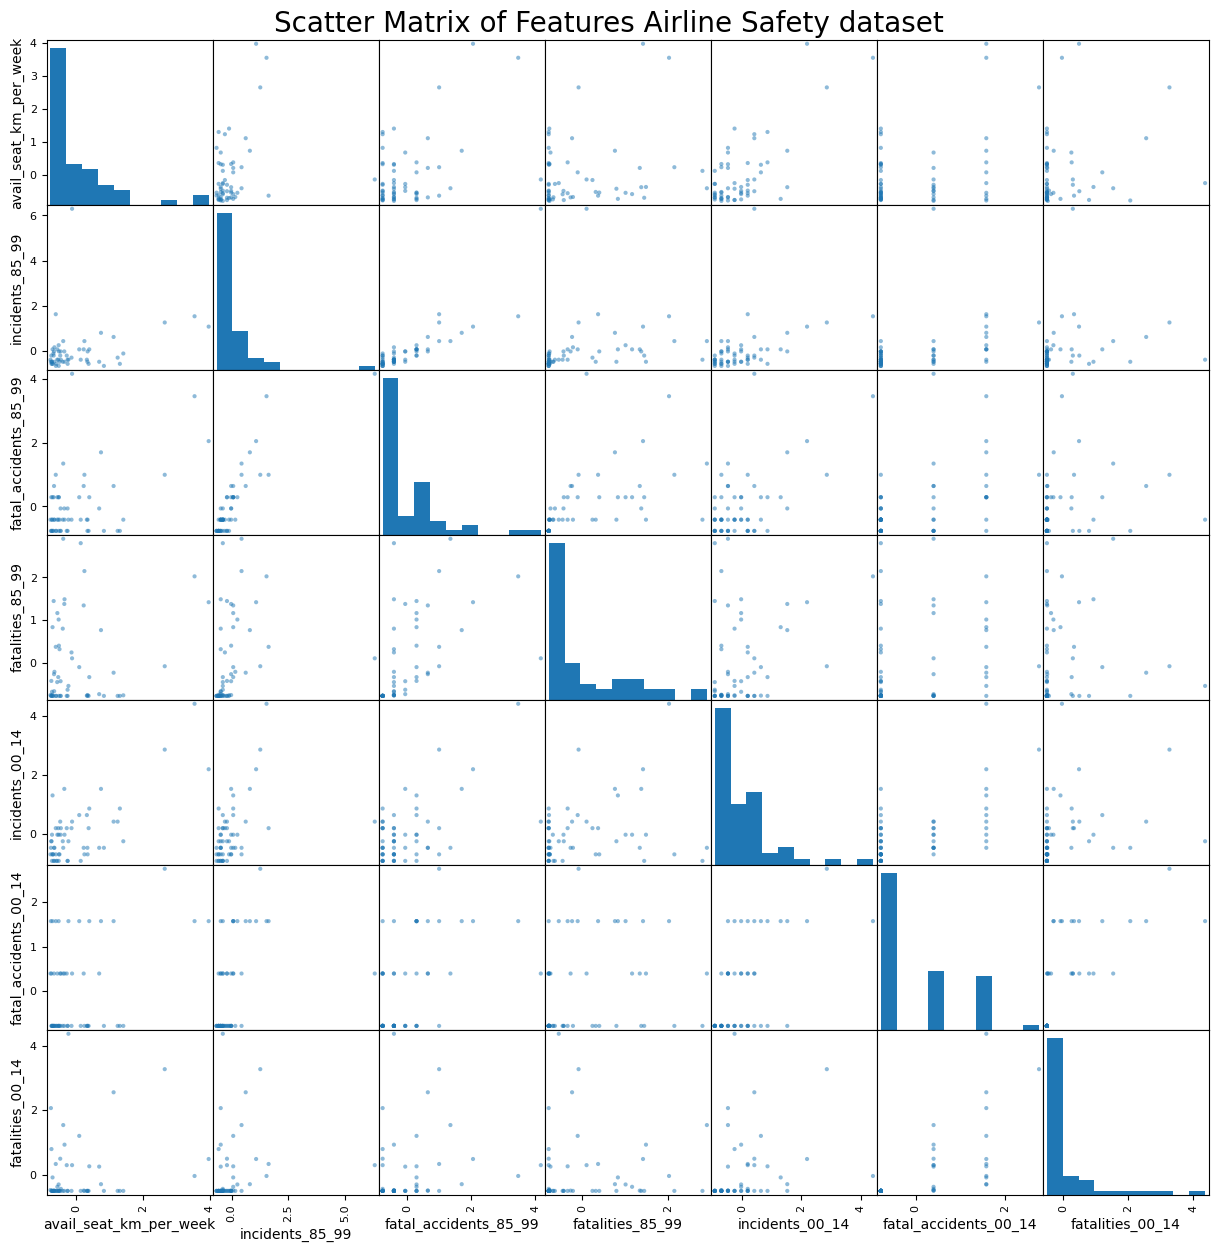

In [51]:
from pandas.plotting import scatter_matrix
import matplotlib.pyplot as plt

scatter_matrix_plot = scatter_matrix(X_scaled_df, figsize=(15,15), diagonal='hist')
plt.suptitle('Scatter Matrix of Features Airline Safety dataset', fontsize=20, y=0.9)     

plt.show()

While scatter plots above offer initial insights into potential clusters, the multidimensional nature of the data requires additional metrics and visualizations for meaningful conclusions. Silhouette scores, elbow method, and dendrograms help analyze optimal cluster numbers and data structure, providing deeper analysis and interpretation. These techniques enhance understanding of similarities and patterns in the dataset, aiding informed conclusions.

## Finding optimal number of clusters

Silhouette score for k=2 : 0.45
Silhouette score for k=3 : 0.4
Silhouette score for k=4 : 0.38
Silhouette score for k=5 : 0.23
Silhouette score for k=6 : 0.26
Silhouette score for k=7 : 0.28
Silhouette score for k=8 : 0.27


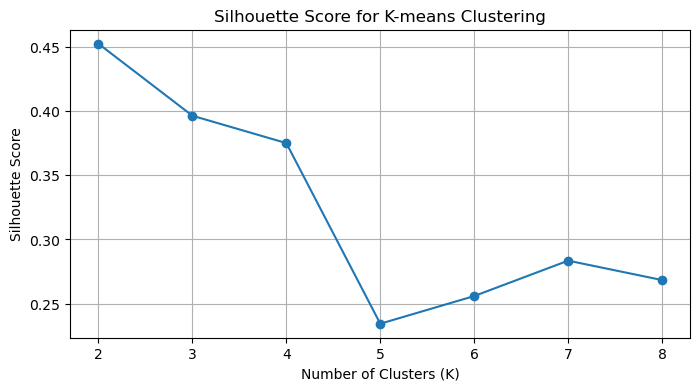

In [52]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

# Set the random state
random_state = 5508

# Define the range of K values
k_values = range(2, 9)

# Initialize an empty list to store the silhouette scores
silhouette_scores = []

kmeans_per_k = []

# Iterate over each K value
for k in k_values:
    # Create the K-means model
    kmeans = KMeans(n_clusters=k, random_state=random_state, n_init="auto")

    # Fit the model to the data
    kmeans.fit(X_scaled_df)
    
    # Append the K-means model to the list
    kmeans_per_k.append(kmeans)

    # Get the cluster labels for each data point
    labels = kmeans.labels_

    # Calculate the silhouette score
    score = silhouette_score(X_scaled_df, labels)
    
    print(f'Silhouette score for k={k} : {round(score, 2)}')

    # Append the silhouette score to the list
    silhouette_scores.append(score)
       

# Plot the silhouette scores
plt.figure(figsize=(8, 4))
plt.plot(k_values, silhouette_scores, marker='o')
plt.xlabel('Number of Clusters (K)')
plt.ylabel('Silhouette Score')
plt.title('Silhouette Score for K-means Clustering')
plt.grid(True)
plt.show()


The analysis of silhouette scores for various values of K suggests that K=2 provides the best clustering solution. The silhouette score of 0.45 indicates a reasonable separation between the clusters, with higher similarity within each cluster. Decreasing silhouette scores for higher K values suggest poorer cluster separation and overlapping clusters. Therefore, K=2 seems reasonable for the task of forming clusters of safe and unsafe airlines.

To visualize the clustering for different values of K, we will utilize silhouette diagrams. These diagrams provide a graphical representation of the silhouette scores, allowing us to assess the quality and consistency of the clusters across various K values.

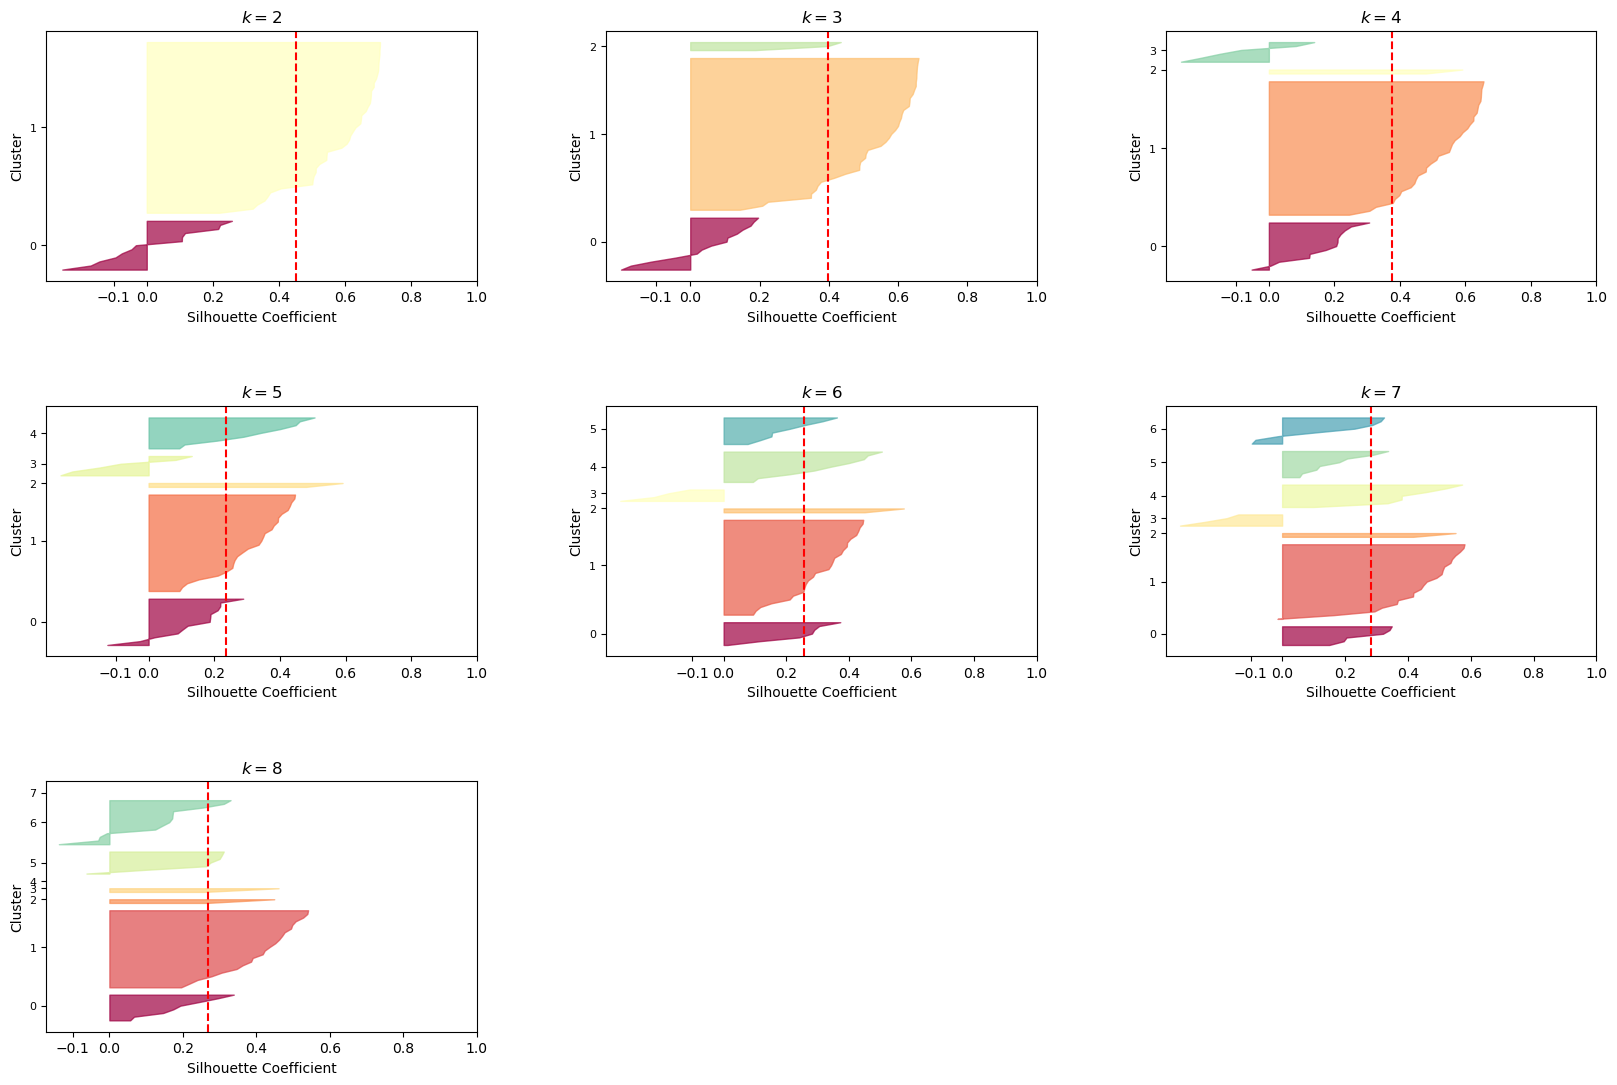

In [53]:
from sklearn.metrics import silhouette_samples
from matplotlib.ticker import FixedLocator, FixedFormatter

plt.figure(figsize=(20, 13))

# Set the spacing around the subplots
plt.subplots_adjust(hspace=0.5, wspace=0.3)

for k in (2, 3, 4, 5, 6, 7, 8):
    plt.subplot(3, 3, k - 1)

    y_pred = kmeans_per_k[k - 2].labels_
    silhouette_coefficients = silhouette_samples(X_scaled_df, y_pred)
   
    padding = len(X_scaled_df) // 30
    pos = padding
    ticks = []
    for i in range(k):
        coeffs = silhouette_coefficients[y_pred == i]              
        coeffs.sort()

        color = plt.cm.Spectral(i / k)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(k)))

    # Adjust the font size of y-axis tick labels
    plt.gca().yaxis.set_tick_params(labelsize=8)
    
    plt.ylabel("Cluster")
    plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xlabel("Silhouette Coefficient")

    plt.axvline(x=silhouette_scores[k - 2], color="red", linestyle="--")
    plt.title(f"$k={k}$")

plt.show()

After analyzing the provided silhouette diagram, it becomes evident that the clustering results are unsatisfactory, regardless of the number of clusters. The silhouette coefficients are generally low, indicating poor separation between clusters. Additionally, the knife-shaped representations of clusters reveal instances that are not well-separated or clearly assigned.

Given these findings, it would be beneficial to explore alternative clustering algorithms, refine the input data, or consider different features to enhance the clustering performance. These steps may help improve the quality and consistency of the clusters.

## Optimal number of clusters

Considering the silhouette scores and the information depicted in the silhouette diagram, we conclude that selecting `k = 2` is the most suitable choice. This decision aligns with our objective of determining whether an airline is safe or not, as it allows for a clear binary classification.

In [54]:
k_optimal = 2

# Perform K-means clustering
kmeans = KMeans(n_clusters=k_optimal, random_state=5508, n_init="auto")
labels = kmeans.fit_predict(X_scaled_df)  # 'data' represents your preprocessed and normalized dataset

In [55]:
print("Silhouette Score (Optimal): ", round(silhouette_score(X_scaled_df, labels), 2))
print("Inertia (Optimal): ", round(kmeans.inertia_,2))

Silhouette Score (Optimal):  0.45
Inertia (Optimal):  255.05


In [56]:
from tabulate import tabulate

# Create an empty dictionary to store the safety records for each cluster
cluster_safety_records = {}

# Iterate over each cluster label and assign the corresponding safety records
for cluster_label in np.unique(labels):
    cluster_data = X[labels == cluster_label]  # Get the data points belonging to the cluster
    avg_safety_records = np.round(np.mean(cluster_data, axis=0)).astype(int)  # Calculate and round average safety records
    
    # Create a dictionary comprehension to store the rounded average safety records
    rounded_safety_records = {column: value for column, value in zip(X.columns, avg_safety_records)}
    
    cluster_safety_records[cluster_label] = rounded_safety_records
 

# Create an empty list to store the table rows
table_rows = []

# Iterate over each cluster label and append the safety records as a table row
for cluster_label, safety_records in cluster_safety_records.items():
    row = [cluster_label] + list(safety_records.values())
    table_rows.append(row)

# Define the table headers
headers = ['Cluster', 'Avail Seat KM', 'Incidents 85-99', 'Fatal Accidents 85-99',
           'Fatalities 85-99', 'Incidents 00-14', 'Fatal Accidents 00-14', 'Fatalities 85-99']

# Print the table
print("Mean of all the features")
print(tabulate(table_rows, headers=headers, tablefmt='pretty'))

Mean of all the features
+---------+---------------+-----------------+-----------------------+------------------+-----------------+-----------------------+------------------+
| Cluster | Avail Seat KM | Incidents 85-99 | Fatal Accidents 85-99 | Fatalities 85-99 | Incidents 00-14 | Fatal Accidents 00-14 | Fatalities 85-99 |
+---------+---------------+-----------------+-----------------------+------------------+-----------------+-----------------------+------------------+
|    0    |  2485294808   |       19        |           6           |       204        |        9        |           2           |       171        |
|    1    |  1051859548   |        4        |           1           |        85        |        3        |           0           |        21        |
+---------+---------------+-----------------+-----------------------+------------------+-----------------+-----------------------+------------------+


Based on these average values, we can interpret the clusters as follows:

**Cluster 0**: Airlines in this cluster have a higher average availability of seat kilometers per week, a relatively higher number of incidents, fatal accidents, and fatalities in both the 1985-1999 and 2000-2014 periods.


**Cluster 1**: Airlines in this cluster have a lower average availability of seat kilometers per week, a lower number of incidents, fatal accidents, and fatalities in both the 1985-1999 and 2000-2014 periods.
It's important to note that these interpretations are based on the provided mean values and may not capture the full context or patterns present in the data. Further analysis and consideration of other factors are necessary for a comprehensive understanding of the airline safety records in each cluster.

## K-means clusters (1985-1999 vs 2000-2014)

### Comparison

In [57]:
from sklearn.cluster import KMeans

K=2
# Selecting variables for the two time periods
variables_85_99 = ['incidents_85_99', 'fatal_accidents_85_99', 'fatalities_85_99']
variables_00_14 = ['incidents_00_14', 'fatal_accidents_00_14', 'fatalities_00_14']

# Creating separate dataframes for each time period
data_85_99 = X_scaled_df[variables_85_99]
data_00_14 = X_scaled_df[variables_00_14]

# Performing K-means clustering for the time period 1985-1999
kmeans_85_99 = KMeans(n_clusters=K, random_state=5508, n_init='auto')
clusters_85_99 = kmeans_85_99.fit_predict(data_85_99)

# Performing K-means clustering for the time period 2000-2014
kmeans_00_14 = KMeans(n_clusters=K, random_state=5508, n_init='auto')
clusters_00_14 = kmeans_00_14.fit_predict(data_00_14)

# Printing instances in clusters for the time period 1985-1999
print("Instances in clusters for the time period 1985-1999:")
for cluster_label in range(K):
    instances = np.where(clusters_85_99 == cluster_label)[0]
    print(f"Cluster {cluster_label}: {instances}")

# Printing instances in clusters for the time period 2000-2014
print("\n\nInstances in clusters for the time period 2000-2014:")
for cluster_label in range(K):
    instances = np.where(clusters_00_14 == cluster_label)[0]
    print(f"Cluster {cluster_label}: {instances}")

Instances in clusters for the time period 1985-1999:
Cluster 0: [ 1  6 11 13 16 19 20 22 24 28 31 35 40 49 51 52]
Cluster 1: [ 0  2  3  4  5  7  8  9 10 12 14 15 17 18 21 23 25 26 27 29 30 32 33 34
 36 37 38 39 41 42 43 44 45 46 47 48 50 53 54 55]


Instances in clusters for the time period 2000-2014:
Cluster 0: [ 1  5  6  8 11 16 19 22 24 25 29 34 35 39 47 50 51 52]
Cluster 1: [ 0  2  3  4  7  9 10 12 13 14 15 17 18 20 21 23 26 27 28 30 31 32 33 36
 37 38 40 41 42 43 44 45 46 48 49 53 54 55]


In [58]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.ticker import FixedLocator, FixedFormatter
from sklearn.metrics import silhouette_samples, silhouette_score

def plot_silhouette_diagram(X, clusters, title=""):
    silhouette_coefficients = silhouette_samples(X, clusters)
    num_clusters = len(np.unique(clusters))

    # Set the spacing around the subplots
    plt.subplots_adjust(hspace=0.5, wspace=0.3)

    padding = len(X) // 30
    pos = padding
    ticks = []
    for i in range(num_clusters):
        coeffs = silhouette_coefficients[clusters == i]
        coeffs.sort()

        color = plt.cm.Spectral(i / num_clusters)
        plt.fill_betweenx(np.arange(pos, pos + len(coeffs)), 0, coeffs,
                          facecolor=color, edgecolor=color, alpha=0.7)
        ticks.append(pos + len(coeffs) // 2)
        pos += len(coeffs) + padding

    plt.gca().yaxis.set_major_locator(FixedLocator(ticks))
    plt.gca().yaxis.set_major_formatter(FixedFormatter(range(num_clusters)))

    # Adjust the font size of y-axis tick labels
    plt.gca().yaxis.set_tick_params(labelsize=8)

    plt.ylabel("Cluster")
    plt.gca().set_xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
    plt.xlabel("Silhouette Coefficient")

    plt.axvline(x=silhouette_score(X, clusters), color="red", linestyle="--")
    plt.title(f"{title}")

    plt.show()


In [59]:
print(f'Inertia (1985-1999) : {round(kmeans_85_99.inertia_, 3)}')
print(f'Inertia (2000-2014) : {round(kmeans_00_14.inertia_, 3)}')

Inertia (1985-1999) : 90.053
Inertia (2000-2014) : 83.916


The lower the inertia, the better the clustering performance. In this case, we observe that the model achieved a lower inertia value for the 2000-2014 period, indicating better clustering results compared to the 1985-1999 period.

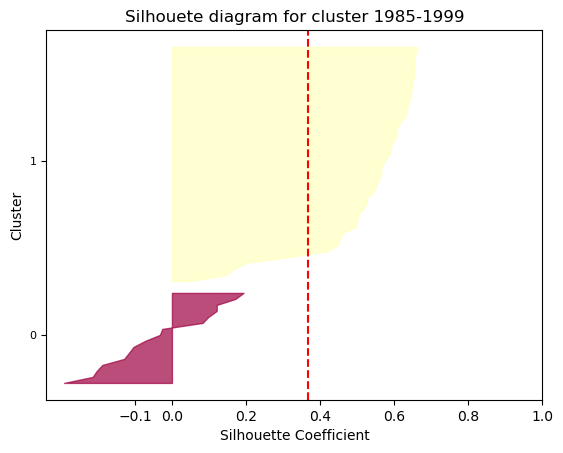

In [60]:
plot_silhouette_diagram(X_scaled_df, clusters_85_99, "Silhouete diagram for cluster 1985-1999")

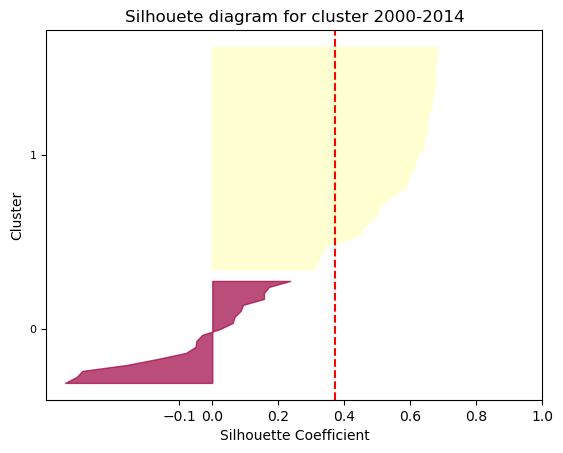

In [61]:
plot_silhouette_diagram(X_scaled_df, clusters_00_14, "Silhouete diagram for cluster 2000-2014")

In [62]:
print(f'Silhouette Score (1985-1999) : {round(silhouette_score(X_scaled_df, clusters_85_99), 3)}')
print(f'Silhouette Score (2000-2014) : {round(silhouette_score(X_scaled_df, clusters_00_14), 3)}')

Silhouette Score (1985-1999) : 0.366
Silhouette Score (2000-2014) : 0.371


In this comparison, we can see that the silhouette score is slightly higher for the 2000-2014 period, indicating slightly better clustering performance compared to the 1985-1999 period. However, the change is not significant which is evident from the diagram above. Both the diagram shows that there are instances that belong to wrong cluster.

### Change in clusters

In [63]:
instances_85_99 = np.arange(len(clusters_85_99))
instances_00_14 = np.arange(len(clusters_00_14))

differences = []

for instance in instances_85_99:
    if clusters_85_99[instance] != clusters_00_14[instance]:
        differences.append((instance, clusters_85_99[instance], clusters_00_14[instance]))

# Printing the list of instances that were classified in different clusters
print("Instances that were classified in different clusters between 1985-1999 and 2000-2014:\n")
print("| Instance | Cluster 1985-1999 | Cluster 2000-2014 |")
print("|----------|-------------------|-------------------|")
for diff in differences:
    print(f"| {diff[0]:^8} | {diff[1]:^17} | {diff[2]:^17} |")


Instances that were classified in different clusters between 1985-1999 and 2000-2014:

| Instance | Cluster 1985-1999 | Cluster 2000-2014 |
|----------|-------------------|-------------------|
|    5     |         1         |         0         |
|    8     |         1         |         0         |
|    13    |         0         |         1         |
|    20    |         0         |         1         |
|    25    |         1         |         0         |
|    28    |         0         |         1         |
|    29    |         1         |         0         |
|    31    |         0         |         1         |
|    34    |         1         |         0         |
|    39    |         1         |         0         |
|    40    |         0         |         1         |
|    47    |         1         |         0         |
|    49    |         0         |         1         |
|    50    |         1         |         0         |


The clusters changed between the time periods 1985-1999 and 2000-2014. This can be observed from the instances that were classified in different clusters in the two time periods.

From the table, we can see that several instances (5, 8, 13, 20, 25, 28, 29, 31, 34, 39, 40, 47, 49, and 50) were initially assigned to Cluster 1 in the time period 1985-1999, but they were assigned to Cluster 0 in the time period 2000-2014. Similarly, some instances (13, 20, 28, 31, 34, 39, 40, 49, and 50) were initially assigned to Cluster 0 in the time period 1985-1999, but they were assigned to Cluster 1 in the time period 2000-2014.

These changes in cluster assignments indicate that the clustering results varied between the two time periods. It suggests that the patterns or characteristics of the instances might have shifted over time, leading to different grouping or clustering behavior. Factors such as changes in airline operations, safety measures, industry regulations, or technological advancements could potentially influence these changes.


## Additional Features

We will derive three new features as the ratio of the variables from 2000-2014 divided by the respective variables from 1985-1999 perform a K-means cluster analysis, considering the value of k=2 from Task 1.

In [64]:
k = 2  # Chosen value of K from Task 1

# Calculate the ratio features
X['incidents_ratio'] = X['incidents_00_14'] / X['incidents_85_99']
X['fatal_accidents_ratio'] = X['fatal_accidents_00_14'] / X['fatal_accidents_85_99']
X['fatalities_ratio'] = X['fatalities_00_14'] / X['fatalities_85_99']

X.head()

,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14,incidents_ratio,fatal_accidents_ratio,fatalities_ratio
0,320906734,2,0,0,0,0,0,0.000000,NaN,NaN
1,1197672318,76,14,128,6,1,88,0.078947,0.071429,0.6875
2,385803648,6,0,0,1,0,0,0.166667,NaN,NaN
3,596871813,3,1,64,5,0,0,1.666667,0.000000,0.0000
4,1865253802,2,0,0,2,0,0,1.000000,NaN,NaN


We will calculate three new features by taking the ratio of the variables from the period 2000-2014 divided by the respective variables from the period 1985-1999. These new features will be used as inputs for a K-means cluster analysis. We will perform the clustering with a value of k=2, which was determined as the optimal number of clusters in Task 1.

Instead of discarding the rows with NaN or infinite values, we will replace those missing values with the corresponding means of their respective columns. This approach allows us to retain the data points and utilize the average values as replacements, ensuring a complete dataset for further analysis.

In [65]:
X = X.replace([np.inf, -np.inf], np.nan)

column_means = X.mean()
X = X.fillna(column_means)

X.head()

,avail_seat_km_per_week,incidents_85_99,fatal_accidents_85_99,fatalities_85_99,incidents_00_14,fatal_accidents_00_14,fatalities_00_14,incidents_ratio,fatal_accidents_ratio,fatalities_ratio
0,320906734,2,0,0,0,0,0,0.000000,0.267705,1.161524
1,1197672318,76,14,128,6,1,88,0.078947,0.071429,0.687500
2,385803648,6,0,0,1,0,0,0.166667,0.267705,1.161524
3,596871813,3,1,64,5,0,0,1.666667,0.000000,0.000000
4,1865253802,2,0,0,2,0,0,1.000000,0.267705,1.161524


In [66]:
from sklearn.preprocessing import StandardScaler

std_scaler = StandardScaler()
X_ratio_scaled = std_scaler.fit_transform(X)

### KMeans Clustering on new features

In [67]:
# Perform K-means clustering
kmeans_ratios = KMeans(n_clusters=2, random_state=5508, n_init='auto')
labels_ratios = kmeans_ratios.fit_predict(X_ratio_scaled)

In [68]:
from tabulate import tabulate

# Create an empty dictionary to store the safety records for each cluster
cluster_safety_records = {}

# Iterate over each cluster label and assign the corresponding safety records
for cluster_label in np.unique(labels_ratios):
    cluster_data = X[labels_ratios == cluster_label]  # Get the data points belonging to the cluster
    avg_safety_records = np.round(np.mean(cluster_data, axis=0)).astype(int)  # Calculate and round average safety records
    
    # Create a dictionary comprehension to store the rounded average safety records
    rounded_safety_records = {column: value for column, value in zip(X.columns, avg_safety_records)}
    
    cluster_safety_records[cluster_label] = rounded_safety_records
from tabulate import tabulate

headers = [
    'Airline',
    'ASW',
    'I (85-99)',
    'F A(85-99)',
    'F(85-99)',
    'I(00-14)',
    'F A (00-14)',
    'F (00-14)',
    'I R',
    'F A R',
    'F R'
]

rows = []
for airline_id, airline_data in cluster_safety_records.items():
    row = [
        airline_id,
        airline_data['avail_seat_km_per_week'],
        airline_data['incidents_85_99'],
        airline_data['fatal_accidents_85_99'],
        airline_data['fatalities_85_99'],
        airline_data['incidents_00_14'],
        airline_data['fatal_accidents_00_14'],
        airline_data['fatalities_00_14'],
        airline_data['incidents_ratio'],
        airline_data['fatal_accidents_ratio'],
        airline_data['fatalities_ratio']
    ]
    rows.append(row)

table = tabulate(rows, headers=headers, tablefmt='fancy_grid')
print(table)


╒═══════════╤════════════╤═════════════╤══════════════╤════════════╤════════════╤═══════════════╤═════════════╤═══════╤═════════╤═══════╕
│   Airline │        ASW │   I (85-99) │   F A(85-99) │   F(85-99) │   I(00-14) │   F A (00-14) │   F (00-14) │   I R │   F A R │   F R │
╞═══════════╪════════════╪═════════════╪══════════════╪════════════╪════════════╪═══════════════╪═════════════╪═══════╪═════════╪═══════╡
│         0 │ 1078276967 │           5 │            1 │        100 │          3 │             1 │          47 │     1 │       0 │     1 │
├───────────┼────────────┼─────────────┼──────────────┼────────────┼────────────┼───────────────┼─────────────┼───────┼─────────┼───────┤
│         1 │ 4509333546 │          31 │            9 │        236 │         14 │             2 │         137 │     1 │       0 │     1 │
╘═══════════╧════════════╧═════════════╧══════════════╧════════════╧════════════╧═══════════════╧═════════════╧═══════╧═════════╧═══════╛


From the table above, we can observe the following characteristics:

Cluster 0: This cluster has relatively lower values for most attributes compared to Cluster 1. It has a lower number of incidents, fatal accidents, and fatalities in both the 1985-1999 and 2000-2014 periods. The incidents_ratio, fatal_accidents_ratio, and fatalities_ratio are all 1, indicating that the ratio of incidents, fatal accidents, and fatalities from 2000-2014 to 1985-1999 is the same. Overall, this cluster represents an airline with lower incidences of incidents, accidents, and fatalities.

Cluster 1: This cluster has higher values for most attributes compared to Cluster 0. It has a higher number of incidents, fatal accidents, and fatalities in both the 1985-1999 and 2000-2014 periods. Similar to Cluster 0, the incidents_ratio, fatal_accidents_ratio, and fatalities_ratio are all 1, indicating the same ratio of incidents, fatal accidents, and fatalities from 2000-2014 to 1985-1999. This cluster represents an airline with a higher incidence of incidents, accidents, and fatalities.

**In summary, based on the mean values, Cluster 0 represents an airline with lower incidences of incidents, accidents, and fatalities, while Cluster 1 represents an airline with higher incidences in these areas.**

In [69]:
# Printing instances in clusters for the time period 1985-1999
print("Instances in clusters")
for cluster_label in range(K):
    instances = np.where(labels_ratios == cluster_label)[0]
    print(f"Cluster {cluster_label}: {instances}")

Instances in clusters
Cluster 0: [ 0  2  3  4  5  6  7  8  9 10 12 13 14 15 16 17 18 20 21 22 23 24 25 26
 27 28 29 30 31 32 33 34 35 36 37 38 39 40 41 42 43 44 45 46 47 48 49 50
 53 54 55]
Cluster 1: [ 1 11 19 51 52]


Based on the analysis of the clusters, we can observe that the airlines **Aeroflot, American, Delta/Northwest, United Continental, and US Airways/America West** are grouped together in Cluster 1. This cluster is characterized by higher incidents, accidents, and fatalities compared to Cluster 0. 

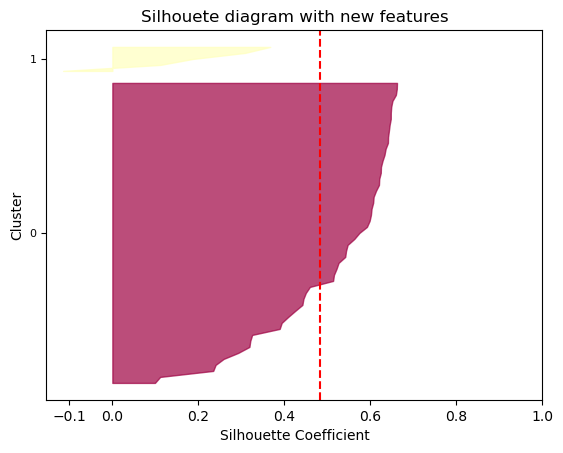

In [70]:
plot_silhouette_diagram(X_ratio_scaled, labels_ratios, "Silhouete diagram with new features")

In [71]:
print("Silhouette Score with new features: ", round(silhouette_score(X_ratio_scaled, labels_ratios), 2))
print("Inertia with new features: ", round(kmeans_ratios.inertia_,2))

Silhouette Score with new features:  0.48
Inertia with new features:  424.95


## Comparisons on the performance

|                | Silhouette Score | Inertia   |
|----------------|------------------|-----------|
| Optimal  (Task 1)      | 0.45             | 255.05    |
| Kmeans (1985-1999)      | 0.366            | 90.053    |
| Kmeans (2000-2014)   | 0.371            | 83.916    |
| Kmeans (New Features)  | 0.48             | 424.95    |



The table provides an overview of the performance metrics for different scenarios in the clustering analysis.

- The "Optimal" scenario from Task 1 has a silhouette coefficient of 0.45, indicating a reasonable **separation** between clusters. The inertia value is 255.05, which represents the sum of squared distances within the clusters. Lower inertia values suggest tighter and compact clustering. However, compared to other clustring, the clusters is more spread out for this scenario. 

- For the Kmeans with variables from 1985-1999, the silhouette score is 0.366, indicating a relatively **lower separation** between clusters compared to the optimal solution. The inertia value is 90.053, which is lower than the optimal inertia indicating **tight cluster**.

- For Kmeans with variables 2000-2014, the silhouette score slightly improves to 0.371, suggesting a slightly **better separation between clusters** compared to Kmeans with variables from 1985-1999. The inertia value decreases to 83.916, indicating a better clustering performance in terms of minimizing distances within clusters.

- The inclusion of new features in the analysis leads to an **improved silhouette score of 0.48, indicating better separation cohesion and seperation between clusters** compared to all the previous scenarios. However, the inertia value increases to 424.95, suggesting a **high dispersion**

Therefore, the choice of the best clustering result depends on the specific evaluation criteria that are prioritized. If maximizing Silhouette Score is more important, then the Kmeans with "New Features" result would be considered the best. On the other hand, if achieving more compact clusters is a priority, then either the K-means result for "1985-1999" or "2000-2014" would be preferred.